# Movie Genre Classification

This notebook looks into using Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting Movie Genre



### Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

### Loading the Dataset

In [2]:
with open("Genre Classification Dataset/train_data.txt", encoding="utf8") as f:train_content = f.readlines()
with open("Genre Classification Dataset/test_data_solution.txt", encoding="utf8") as f:content_test = f.readlines()
train = pd.DataFrame([element.split(":::") for element in train_content], columns=['ID', 'TITLE', "GENRE", 'DESCRIPTION']).drop(columns=['ID'])
test = pd.DataFrame([element.split(":::") for element in content_test], columns=['ID', 'TITLE', "GENRE", 'DESCRIPTION']).drop(columns=['ID'])

In [3]:
train.sample(5)

TITLE     GENRE  \
38751                        The Make Up (2007)     adult    
33233   Un, dos... Un, dos, tres, cuatro (2017)     short    
35348                       Nico: Maputo (2013)     drama    
50920                  The Power of Love (1922)     drama    
33943                            La Isla (2016)    comedy    

                                             DESCRIPTION  
38751   Mandy and Spencer are having relationship iss...  
33233   Ray and Diego, two inseparable friends, casua...  
35348   NICO (Peter P. Gudo) is a true life story abo...  
50920   Because of his financial trouble, Don Almeda ...  
33943   Ibrahim, a Moroccan soldier, is sent to a des...

In [4]:
train.shape, test.shape

((54214, 3), (54200, 3))

## EDA

### Checking null values in train as well as test data

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   TITLE        54214 non-null  object
 1   GENRE        54214 non-null  object
 2   DESCRIPTION  54214 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


### Checking for duplicate values in train and test data

In [6]:
train.duplicated().sum()

0

In [7]:
train.describe()

TITLE    GENRE  \
count                            54214    54214   
unique                           54214       27   
top      Oscar et la dame rose (2009)    drama    
freq                                 1    13613   

                                              DESCRIPTION  
count                                               54214  
unique                                              54086  
top      Grammy - music award of the American academy ...  
freq                                                   12

### Searching For anamalies in the description

In [8]:
# 1. @/twitter in the Description
train.loc[train['DESCRIPTION'].str.contains(r'@\S+')].head()

TITLE          GENRE  \
242    Túlvilági beszélö (1992)    documentary    
1880             Rokonok (1954)          drama    
1986           Lila akác (1934)         comedy    
6579       A csúnya lány (1935)         comedy    
8296   Füszer és csemege (1940)          drama    

                                            DESCRIPTION  
242    Mail <svaradi@sprynet.com> for translation. T...  
1880   Mail <svaradi@sprynet.com> for translation. F...  
1986   Mail <svaradi@sprynet.com> for translation. S...  
6579   Mail <svaradi@sprynet.com> for translation. D...  
8296   Mail <svaradi@sprynet.com> for translation. 5...

In [9]:
# 2. HTTP links in the Description
train.loc[train['DESCRIPTION'].str.contains(r'http\S+')].head()

TITLE          GENRE  \
16974        The Happiness Matrix (2012)    documentary    
20748   Blocking the Path to 9/11 (2008)    documentary    
26257           "Offbeat America" (2005)     reality-tv    
30651              Hollywood Love (1998)         comedy    
33419                    Trust 22 (2007)    documentary    

                                             DESCRIPTION  
16974   Volume 1 of "The Happiness Matrix", a 2-hour ...  
20748   There's more to the story of the Clintons and...  
26257   High Noon Entertainment hosts visit the Asian...  
30651   A feminist sex movie??? http:hollywoodlovemov...  
33419   In this amazing film full of magic the direct...

In [10]:
!pip install langdetect

In [11]:
## 3. Different Languages in the Desciption
from langdetect import detect
lang_count=0
def detect_language(text):
    global lang_count
    lang_count=lang_count+1
    print(lang_count)
    try:
        return detect(text)
    except:
        return 'Unknown'

train['Language'] = train['DESCRIPTION'].apply(detect_language)
test['Language'] = train['DESCRIPTION'].apply(detect_language)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073


3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775


5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462
5463
5464
5465
5466


6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092
7093
7094
7095
7096
7097
7098
7099
7100
7101
7102
7103
7104
7105
7106
7107
7108
7109
7110
7111
7112
7113
7114
7115
7116
7117
7118
7119
7120
7121
7122
7123
7124
7125
7126
7127
7128
7129
7130
7131
7132
7133
7134
7135
7136
7137
7138
7139
7140
7141
7142
7143
7144
7145
7146
7147
7148
7149
7150
7151
7152
7153
7154
7155
7156
7157
7158
7159
7160
7161
7162
7163
7164
7165
7166
7167
7168
7169
7170
7171
7172
7173
7174
7175
7176
7177
7178
7179
7180
7181
7182
7183
7184


8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697
8698
8699
8700
8701
8702
8703
8704
8705
8706
8707
8708
8709
8710
8711
8712
8713
8714
8715
8716
8717
8718
8719
8720
8721
8722
8723
8724
8725
8726
8727
8728
8729
8730
8731
8732
8733
8734
8735
8736
8737
8738
8739
8740
8741
8742
8743
8744
8745
8746
8747
8748
8749
8750
8751
8752
8753
8754
8755
8756
8757
8758
8759
8760
8761
8762
8763
8764
8765
8766
8767
8768
8769
8770
8771
8772
8773
8774
8775
8776
8777
8778
8779
8780
8781
8782
8783
8784
8785
8786
8787
8788
8789
8790
8791
8792
8793
8794
8795
8796
8797
8798
8799
8800
8801
8802
8803
8804
8805
8806
8807
8808
8809
8810
8811
8812
8813
8814
8815
8816
8817
8818
8819
8820
8821
8822
8823
8824
8825
8826
8827
8828
8829
8830
8831
8832
8833
8834
8835
8836
8837
8838
8839
8840
8841
8842
8843
8844
8845
8846
8847
8848
8849
8850
8851
8852
8853
8854
8855
8856
8857
8858
8859
8860
8861
8862
8863
8864
8865
8866
8867
8868
8869
8870
8871
8872
8873
8874
8875
8876
8877
8878
8879
8880
8881


10306
10307
10308
10309
10310
10311
10312
10313
10314
10315
10316
10317
10318
10319
10320
10321
10322
10323
10324
10325
10326
10327
10328
10329
10330
10331
10332
10333
10334
10335
10336
10337
10338
10339
10340
10341
10342
10343
10344
10345
10346
10347
10348
10349
10350
10351
10352
10353
10354
10355
10356
10357
10358
10359
10360
10361
10362
10363
10364
10365
10366
10367
10368
10369
10370
10371
10372
10373
10374
10375
10376
10377
10378
10379
10380
10381
10382
10383
10384
10385
10386
10387
10388
10389
10390
10391
10392
10393
10394
10395
10396
10397
10398
10399
10400
10401
10402
10403
10404
10405
10406
10407
10408
10409
10410
10411
10412
10413
10414
10415
10416
10417
10418
10419
10420
10421
10422
10423
10424
10425
10426
10427
10428
10429
10430
10431
10432
10433
10434
10435
10436
10437
10438
10439
10440
10441
10442
10443
10444
10445
10446
10447
10448
10449
10450
10451
10452
10453
10454
10455
10456
10457
10458
10459
10460
10461
10462
10463
10464
10465
10466
10467
10468
10469
10470
10471
1047

11691
11692
11693
11694
11695
11696
11697
11698
11699
11700
11701
11702
11703
11704
11705
11706
11707
11708
11709
11710
11711
11712
11713
11714
11715
11716
11717
11718
11719
11720
11721
11722
11723
11724
11725
11726
11727
11728
11729
11730
11731
11732
11733
11734
11735
11736
11737
11738
11739
11740
11741
11742
11743
11744
11745
11746
11747
11748
11749
11750
11751
11752
11753
11754
11755
11756
11757
11758
11759
11760
11761
11762
11763
11764
11765
11766
11767
11768
11769
11770
11771
11772
11773
11774
11775
11776
11777
11778
11779
11780
11781
11782
11783
11784
11785
11786
11787
11788
11789
11790
11791
11792
11793
11794
11795
11796
11797
11798
11799
11800
11801
11802
11803
11804
11805
11806
11807
11808
11809
11810
11811
11812
11813
11814
11815
11816
11817
11818
11819
11820
11821
11822
11823
11824
11825
11826
11827
11828
11829
11830
11831
11832
11833
11834
11835
11836
11837
11838
11839
11840
11841
11842
11843
11844
11845
11846
11847
11848
11849
11850
11851
11852
11853
11854
11855
11856
1185

13060
13061
13062
13063
13064
13065
13066
13067
13068
13069
13070
13071
13072
13073
13074
13075
13076
13077
13078
13079
13080
13081
13082
13083
13084
13085
13086
13087
13088
13089
13090
13091
13092
13093
13094
13095
13096
13097
13098
13099
13100
13101
13102
13103
13104
13105
13106
13107
13108
13109
13110
13111
13112
13113
13114
13115
13116
13117
13118
13119
13120
13121
13122
13123
13124
13125
13126
13127
13128
13129
13130
13131
13132
13133
13134
13135
13136
13137
13138
13139
13140
13141
13142
13143
13144
13145
13146
13147
13148
13149
13150
13151
13152
13153
13154
13155
13156
13157
13158
13159
13160
13161
13162
13163
13164
13165
13166
13167
13168
13169
13170
13171
13172
13173
13174
13175
13176
13177
13178
13179
13180
13181
13182
13183
13184
13185
13186
13187
13188
13189
13190
13191
13192
13193
13194
13195
13196
13197
13198
13199
13200
13201
13202
13203
13204
13205
13206
13207
13208
13209
13210
13211
13212
13213
13214
13215
13216
13217
13218
13219
13220
13221
13222
13223
13224
13225
1322

14484
14485
14486
14487
14488
14489
14490
14491
14492
14493
14494
14495
14496
14497
14498
14499
14500
14501
14502
14503
14504
14505
14506
14507
14508
14509
14510
14511
14512
14513
14514
14515
14516
14517
14518
14519
14520
14521
14522
14523
14524
14525
14526
14527
14528
14529
14530
14531
14532
14533
14534
14535
14536
14537
14538
14539
14540
14541
14542
14543
14544
14545
14546
14547
14548
14549
14550
14551
14552
14553
14554
14555
14556
14557
14558
14559
14560
14561
14562
14563
14564
14565
14566
14567
14568
14569
14570
14571
14572
14573
14574
14575
14576
14577
14578
14579
14580
14581
14582
14583
14584
14585
14586
14587
14588
14589
14590
14591
14592
14593
14594
14595
14596
14597
14598
14599
14600
14601
14602
14603
14604
14605
14606
14607
14608
14609
14610
14611
14612
14613
14614
14615
14616
14617
14618
14619
14620
14621
14622
14623
14624
14625
14626
14627
14628
14629
14630
14631
14632
14633
14634
14635
14636
14637
14638
14639
14640
14641
14642
14643
14644
14645
14646
14647
14648
14649
1465

15913
15914
15915
15916
15917
15918
15919
15920
15921
15922
15923
15924
15925
15926
15927
15928
15929
15930
15931
15932
15933
15934
15935
15936
15937
15938
15939
15940
15941
15942
15943
15944
15945
15946
15947
15948
15949
15950
15951
15952
15953
15954
15955
15956
15957
15958
15959
15960
15961
15962
15963
15964
15965
15966
15967
15968
15969
15970
15971
15972
15973
15974
15975
15976
15977
15978
15979
15980
15981
15982
15983
15984
15985
15986
15987
15988
15989
15990
15991
15992
15993
15994
15995
15996
15997
15998
15999
16000
16001
16002
16003
16004
16005
16006
16007
16008
16009
16010
16011
16012
16013
16014
16015
16016
16017
16018
16019
16020
16021
16022
16023
16024
16025
16026
16027
16028
16029
16030
16031
16032
16033
16034
16035
16036
16037
16038
16039
16040
16041
16042
16043
16044
16045
16046
16047
16048
16049
16050
16051
16052
16053
16054
16055
16056
16057
16058
16059
16060
16061
16062
16063
16064
16065
16066
16067
16068
16069
16070
16071
16072
16073
16074
16075
16076
16077
16078
1607

17326
17327
17328
17329
17330
17331
17332
17333
17334
17335
17336
17337
17338
17339
17340
17341
17342
17343
17344
17345
17346
17347
17348
17349
17350
17351
17352
17353
17354
17355
17356
17357
17358
17359
17360
17361
17362
17363
17364
17365
17366
17367
17368
17369
17370
17371
17372
17373
17374
17375
17376
17377
17378
17379
17380
17381
17382
17383
17384
17385
17386
17387
17388
17389
17390
17391
17392
17393
17394
17395
17396
17397
17398
17399
17400
17401
17402
17403
17404
17405
17406
17407
17408
17409
17410
17411
17412
17413
17414
17415
17416
17417
17418
17419
17420
17421
17422
17423
17424
17425
17426
17427
17428
17429
17430
17431
17432
17433
17434
17435
17436
17437
17438
17439
17440
17441
17442
17443
17444
17445
17446
17447
17448
17449
17450
17451
17452
17453
17454
17455
17456
17457
17458
17459
17460
17461
17462
17463
17464
17465
17466
17467
17468
17469
17470
17471
17472
17473
17474
17475
17476
17477
17478
17479
17480
17481
17482
17483
17484
17485
17486
17487
17488
17489
17490
17491
1749

18708
18709
18710
18711
18712
18713
18714
18715
18716
18717
18718
18719
18720
18721
18722
18723
18724
18725
18726
18727
18728
18729
18730
18731
18732
18733
18734
18735
18736
18737
18738
18739
18740
18741
18742
18743
18744
18745
18746
18747
18748
18749
18750
18751
18752
18753
18754
18755
18756
18757
18758
18759
18760
18761
18762
18763
18764
18765
18766
18767
18768
18769
18770
18771
18772
18773
18774
18775
18776
18777
18778
18779
18780
18781
18782
18783
18784
18785
18786
18787
18788
18789
18790
18791
18792
18793
18794
18795
18796
18797
18798
18799
18800
18801
18802
18803
18804
18805
18806
18807
18808
18809
18810
18811
18812
18813
18814
18815
18816
18817
18818
18819
18820
18821
18822
18823
18824
18825
18826
18827
18828
18829
18830
18831
18832
18833
18834
18835
18836
18837
18838
18839
18840
18841
18842
18843
18844
18845
18846
18847
18848
18849
18850
18851
18852
18853
18854
18855
18856
18857
18858
18859
18860
18861
18862
18863
18864
18865
18866
18867
18868
18869
18870
18871
18872
18873
1887

20125
20126
20127
20128
20129
20130
20131
20132
20133
20134
20135
20136
20137
20138
20139
20140
20141
20142
20143
20144
20145
20146
20147
20148
20149
20150
20151
20152
20153
20154
20155
20156
20157
20158
20159
20160
20161
20162
20163
20164
20165
20166
20167
20168
20169
20170
20171
20172
20173
20174
20175
20176
20177
20178
20179
20180
20181
20182
20183
20184
20185
20186
20187
20188
20189
20190
20191
20192
20193
20194
20195
20196
20197
20198
20199
20200
20201
20202
20203
20204
20205
20206
20207
20208
20209
20210
20211
20212
20213
20214
20215
20216
20217
20218
20219
20220
20221
20222
20223
20224
20225
20226
20227
20228
20229
20230
20231
20232
20233
20234
20235
20236
20237
20238
20239
20240
20241
20242
20243
20244
20245
20246
20247
20248
20249
20250
20251
20252
20253
20254
20255
20256
20257
20258
20259
20260
20261
20262
20263
20264
20265
20266
20267
20268
20269
20270
20271
20272
20273
20274
20275
20276
20277
20278
20279
20280
20281
20282
20283
20284
20285
20286
20287
20288
20289
20290
2029

21517
21518
21519
21520
21521
21522
21523
21524
21525
21526
21527
21528
21529
21530
21531
21532
21533
21534
21535
21536
21537
21538
21539
21540
21541
21542
21543
21544
21545
21546
21547
21548
21549
21550
21551
21552
21553
21554
21555
21556
21557
21558
21559
21560
21561
21562
21563
21564
21565
21566
21567
21568
21569
21570
21571
21572
21573
21574
21575
21576
21577
21578
21579
21580
21581
21582
21583
21584
21585
21586
21587
21588
21589
21590
21591
21592
21593
21594
21595
21596
21597
21598
21599
21600
21601
21602
21603
21604
21605
21606
21607
21608
21609
21610
21611
21612
21613
21614
21615
21616
21617
21618
21619
21620
21621
21622
21623
21624
21625
21626
21627
21628
21629
21630
21631
21632
21633
21634
21635
21636
21637
21638
21639
21640
21641
21642
21643
21644
21645
21646
21647
21648
21649
21650
21651
21652
21653
21654
21655
21656
21657
21658
21659
21660
21661
21662
21663
21664
21665
21666
21667
21668
21669
21670
21671
21672
21673
21674
21675
21676
21677
21678
21679
21680
21681
21682
2168

22890
22891
22892
22893
22894
22895
22896
22897
22898
22899
22900
22901
22902
22903
22904
22905
22906
22907
22908
22909
22910
22911
22912
22913
22914
22915
22916
22917
22918
22919
22920
22921
22922
22923
22924
22925
22926
22927
22928
22929
22930
22931
22932
22933
22934
22935
22936
22937
22938
22939
22940
22941
22942
22943
22944
22945
22946
22947
22948
22949
22950
22951
22952
22953
22954
22955
22956
22957
22958
22959
22960
22961
22962
22963
22964
22965
22966
22967
22968
22969
22970
22971
22972
22973
22974
22975
22976
22977
22978
22979
22980
22981
22982
22983
22984
22985
22986
22987
22988
22989
22990
22991
22992
22993
22994
22995
22996
22997
22998
22999
23000
23001
23002
23003
23004
23005
23006
23007
23008
23009
23010
23011
23012
23013
23014
23015
23016
23017
23018
23019
23020
23021
23022
23023
23024
23025
23026
23027
23028
23029
23030
23031
23032
23033
23034
23035
23036
23037
23038
23039
23040
23041
23042
23043
23044
23045
23046
23047
23048
23049
23050
23051
23052
23053
23054
23055
2305

24313
24314
24315
24316
24317
24318
24319
24320
24321
24322
24323
24324
24325
24326
24327
24328
24329
24330
24331
24332
24333
24334
24335
24336
24337
24338
24339
24340
24341
24342
24343
24344
24345
24346
24347
24348
24349
24350
24351
24352
24353
24354
24355
24356
24357
24358
24359
24360
24361
24362
24363
24364
24365
24366
24367
24368
24369
24370
24371
24372
24373
24374
24375
24376
24377
24378
24379
24380
24381
24382
24383
24384
24385
24386
24387
24388
24389
24390
24391
24392
24393
24394
24395
24396
24397
24398
24399
24400
24401
24402
24403
24404
24405
24406
24407
24408
24409
24410
24411
24412
24413
24414
24415
24416
24417
24418
24419
24420
24421
24422
24423
24424
24425
24426
24427
24428
24429
24430
24431
24432
24433
24434
24435
24436
24437
24438
24439
24440
24441
24442
24443
24444
24445
24446
24447
24448
24449
24450
24451
24452
24453
24454
24455
24456
24457
24458
24459
24460
24461
24462
24463
24464
24465
24466
24467
24468
24469
24470
24471
24472
24473
24474
24475
24476
24477
24478
2447

25755
25756
25757
25758
25759
25760
25761
25762
25763
25764
25765
25766
25767
25768
25769
25770
25771
25772
25773
25774
25775
25776
25777
25778
25779
25780
25781
25782
25783
25784
25785
25786
25787
25788
25789
25790
25791
25792
25793
25794
25795
25796
25797
25798
25799
25800
25801
25802
25803
25804
25805
25806
25807
25808
25809
25810
25811
25812
25813
25814
25815
25816
25817
25818
25819
25820
25821
25822
25823
25824
25825
25826
25827
25828
25829
25830
25831
25832
25833
25834
25835
25836
25837
25838
25839
25840
25841
25842
25843
25844
25845
25846
25847
25848
25849
25850
25851
25852
25853
25854
25855
25856
25857
25858
25859
25860
25861
25862
25863
25864
25865
25866
25867
25868
25869
25870
25871
25872
25873
25874
25875
25876
25877
25878
25879
25880
25881
25882
25883
25884
25885
25886
25887
25888
25889
25890
25891
25892
25893
25894
25895
25896
25897
25898
25899
25900
25901
25902
25903
25904
25905
25906
25907
25908
25909
25910
25911
25912
25913
25914
25915
25916
25917
25918
25919
25920
2592

27139
27140
27141
27142
27143
27144
27145
27146
27147
27148
27149
27150
27151
27152
27153
27154
27155
27156
27157
27158
27159
27160
27161
27162
27163
27164
27165
27166
27167
27168
27169
27170
27171
27172
27173
27174
27175
27176
27177
27178
27179
27180
27181
27182
27183
27184
27185
27186
27187
27188
27189
27190
27191
27192
27193
27194
27195
27196
27197
27198
27199
27200
27201
27202
27203
27204
27205
27206
27207
27208
27209
27210
27211
27212
27213
27214
27215
27216
27217
27218
27219
27220
27221
27222
27223
27224
27225
27226
27227
27228
27229
27230
27231
27232
27233
27234
27235
27236
27237
27238
27239
27240
27241
27242
27243
27244
27245
27246
27247
27248
27249
27250
27251
27252
27253
27254
27255
27256
27257
27258
27259
27260
27261
27262
27263
27264
27265
27266
27267
27268
27269
27270
27271
27272
27273
27274
27275
27276
27277
27278
27279
27280
27281
27282
27283
27284
27285
27286
27287
27288
27289
27290
27291
27292
27293
27294
27295
27296
27297
27298
27299
27300
27301
27302
27303
27304
2730

28533
28534
28535
28536
28537
28538
28539
28540
28541
28542
28543
28544
28545
28546
28547
28548
28549
28550
28551
28552
28553
28554
28555
28556
28557
28558
28559
28560
28561
28562
28563
28564
28565
28566
28567
28568
28569
28570
28571
28572
28573
28574
28575
28576
28577
28578
28579
28580
28581
28582
28583
28584
28585
28586
28587
28588
28589
28590
28591
28592
28593
28594
28595
28596
28597
28598
28599
28600
28601
28602
28603
28604
28605
28606
28607
28608
28609
28610
28611
28612
28613
28614
28615
28616
28617
28618
28619
28620
28621
28622
28623
28624
28625
28626
28627
28628
28629
28630
28631
28632
28633
28634
28635
28636
28637
28638
28639
28640
28641
28642
28643
28644
28645
28646
28647
28648
28649
28650
28651
28652
28653
28654
28655
28656
28657
28658
28659
28660
28661
28662
28663
28664
28665
28666
28667
28668
28669
28670
28671
28672
28673
28674
28675
28676
28677
28678
28679
28680
28681
28682
28683
28684
28685
28686
28687
28688
28689
28690
28691
28692
28693
28694
28695
28696
28697
28698
2869

29911
29912
29913
29914
29915
29916
29917
29918
29919
29920
29921
29922
29923
29924
29925
29926
29927
29928
29929
29930
29931
29932
29933
29934
29935
29936
29937
29938
29939
29940
29941
29942
29943
29944
29945
29946
29947
29948
29949
29950
29951
29952
29953
29954
29955
29956
29957
29958
29959
29960
29961
29962
29963
29964
29965
29966
29967
29968
29969
29970
29971
29972
29973
29974
29975
29976
29977
29978
29979
29980
29981
29982
29983
29984
29985
29986
29987
29988
29989
29990
29991
29992
29993
29994
29995
29996
29997
29998
29999
30000
30001
30002
30003
30004
30005
30006
30007
30008
30009
30010
30011
30012
30013
30014
30015
30016
30017
30018
30019
30020
30021
30022
30023
30024
30025
30026
30027
30028
30029
30030
30031
30032
30033
30034
30035
30036
30037
30038
30039
30040
30041
30042
30043
30044
30045
30046
30047
30048
30049
30050
30051
30052
30053
30054
30055
30056
30057
30058
30059
30060
30061
30062
30063
30064
30065
30066
30067
30068
30069
30070
30071
30072
30073
30074
30075
30076
3007

31321
31322
31323
31324
31325
31326
31327
31328
31329
31330
31331
31332
31333
31334
31335
31336
31337
31338
31339
31340
31341
31342
31343
31344
31345
31346
31347
31348
31349
31350
31351
31352
31353
31354
31355
31356
31357
31358
31359
31360
31361
31362
31363
31364
31365
31366
31367
31368
31369
31370
31371
31372
31373
31374
31375
31376
31377
31378
31379
31380
31381
31382
31383
31384
31385
31386
31387
31388
31389
31390
31391
31392
31393
31394
31395
31396
31397
31398
31399
31400
31401
31402
31403
31404
31405
31406
31407
31408
31409
31410
31411
31412
31413
31414
31415
31416
31417
31418
31419
31420
31421
31422
31423
31424
31425
31426
31427
31428
31429
31430
31431
31432
31433
31434
31435
31436
31437
31438
31439
31440
31441
31442
31443
31444
31445
31446
31447
31448
31449
31450
31451
31452
31453
31454
31455
31456
31457
31458
31459
31460
31461
31462
31463
31464
31465
31466
31467
31468
31469
31470
31471
31472
31473
31474
31475
31476
31477
31478
31479
31480
31481
31482
31483
31484
31485
31486
3148

32718
32719
32720
32721
32722
32723
32724
32725
32726
32727
32728
32729
32730
32731
32732
32733
32734
32735
32736
32737
32738
32739
32740
32741
32742
32743
32744
32745
32746
32747
32748
32749
32750
32751
32752
32753
32754
32755
32756
32757
32758
32759
32760
32761
32762
32763
32764
32765
32766
32767
32768
32769
32770
32771
32772
32773
32774
32775
32776
32777
32778
32779
32780
32781
32782
32783
32784
32785
32786
32787
32788
32789
32790
32791
32792
32793
32794
32795
32796
32797
32798
32799
32800
32801
32802
32803
32804
32805
32806
32807
32808
32809
32810
32811
32812
32813
32814
32815
32816
32817
32818
32819
32820
32821
32822
32823
32824
32825
32826
32827
32828
32829
32830
32831
32832
32833
32834
32835
32836
32837
32838
32839
32840
32841
32842
32843
32844
32845
32846
32847
32848
32849
32850
32851
32852
32853
32854
32855
32856
32857
32858
32859
32860
32861
32862
32863
32864
32865
32866
32867
32868
32869
32870
32871
32872
32873
32874
32875
32876
32877
32878
32879
32880
32881
32882
32883
3288

34110
34111
34112
34113
34114
34115
34116
34117
34118
34119
34120
34121
34122
34123
34124
34125
34126
34127
34128
34129
34130
34131
34132
34133
34134
34135
34136
34137
34138
34139
34140
34141
34142
34143
34144
34145
34146
34147
34148
34149
34150
34151
34152
34153
34154
34155
34156
34157
34158
34159
34160
34161
34162
34163
34164
34165
34166
34167
34168
34169
34170
34171
34172
34173
34174
34175
34176
34177
34178
34179
34180
34181
34182
34183
34184
34185
34186
34187
34188
34189
34190
34191
34192
34193
34194
34195
34196
34197
34198
34199
34200
34201
34202
34203
34204
34205
34206
34207
34208
34209
34210
34211
34212
34213
34214
34215
34216
34217
34218
34219
34220
34221
34222
34223
34224
34225
34226
34227
34228
34229
34230
34231
34232
34233
34234
34235
34236
34237
34238
34239
34240
34241
34242
34243
34244
34245
34246
34247
34248
34249
34250
34251
34252
34253
34254
34255
34256
34257
34258
34259
34260
34261
34262
34263
34264
34265
34266
34267
34268
34269
34270
34271
34272
34273
34274
34275
3427

35518
35519
35520
35521
35522
35523
35524
35525
35526
35527
35528
35529
35530
35531
35532
35533
35534
35535
35536
35537
35538
35539
35540
35541
35542
35543
35544
35545
35546
35547
35548
35549
35550
35551
35552
35553
35554
35555
35556
35557
35558
35559
35560
35561
35562
35563
35564
35565
35566
35567
35568
35569
35570
35571
35572
35573
35574
35575
35576
35577
35578
35579
35580
35581
35582
35583
35584
35585
35586
35587
35588
35589
35590
35591
35592
35593
35594
35595
35596
35597
35598
35599
35600
35601
35602
35603
35604
35605
35606
35607
35608
35609
35610
35611
35612
35613
35614
35615
35616
35617
35618
35619
35620
35621
35622
35623
35624
35625
35626
35627
35628
35629
35630
35631
35632
35633
35634
35635
35636
35637
35638
35639
35640
35641
35642
35643
35644
35645
35646
35647
35648
35649
35650
35651
35652
35653
35654
35655
35656
35657
35658
35659
35660
35661
35662
35663
35664
35665
35666
35667
35668
35669
35670
35671
35672
35673
35674
35675
35676
35677
35678
35679
35680
35681
35682
35683
3568

36888
36889
36890
36891
36892
36893
36894
36895
36896
36897
36898
36899
36900
36901
36902
36903
36904
36905
36906
36907
36908
36909
36910
36911
36912
36913
36914
36915
36916
36917
36918
36919
36920
36921
36922
36923
36924
36925
36926
36927
36928
36929
36930
36931
36932
36933
36934
36935
36936
36937
36938
36939
36940
36941
36942
36943
36944
36945
36946
36947
36948
36949
36950
36951
36952
36953
36954
36955
36956
36957
36958
36959
36960
36961
36962
36963
36964
36965
36966
36967
36968
36969
36970
36971
36972
36973
36974
36975
36976
36977
36978
36979
36980
36981
36982
36983
36984
36985
36986
36987
36988
36989
36990
36991
36992
36993
36994
36995
36996
36997
36998
36999
37000
37001
37002
37003
37004
37005
37006
37007
37008
37009
37010
37011
37012
37013
37014
37015
37016
37017
37018
37019
37020
37021
37022
37023
37024
37025
37026
37027
37028
37029
37030
37031
37032
37033
37034
37035
37036
37037
37038
37039
37040
37041
37042
37043
37044
37045
37046
37047
37048
37049
37050
37051
37052
37053
3705

38259
38260
38261
38262
38263
38264
38265
38266
38267
38268
38269
38270
38271
38272
38273
38274
38275
38276
38277
38278
38279
38280
38281
38282
38283
38284
38285
38286
38287
38288
38289
38290
38291
38292
38293
38294
38295
38296
38297
38298
38299
38300
38301
38302
38303
38304
38305
38306
38307
38308
38309
38310
38311
38312
38313
38314
38315
38316
38317
38318
38319
38320
38321
38322
38323
38324
38325
38326
38327
38328
38329
38330
38331
38332
38333
38334
38335
38336
38337
38338
38339
38340
38341
38342
38343
38344
38345
38346
38347
38348
38349
38350
38351
38352
38353
38354
38355
38356
38357
38358
38359
38360
38361
38362
38363
38364
38365
38366
38367
38368
38369
38370
38371
38372
38373
38374
38375
38376
38377
38378
38379
38380
38381
38382
38383
38384
38385
38386
38387
38388
38389
38390
38391
38392
38393
38394
38395
38396
38397
38398
38399
38400
38401
38402
38403
38404
38405
38406
38407
38408
38409
38410
38411
38412
38413
38414
38415
38416
38417
38418
38419
38420
38421
38422
38423
38424
3842

39634
39635
39636
39637
39638
39639
39640
39641
39642
39643
39644
39645
39646
39647
39648
39649
39650
39651
39652
39653
39654
39655
39656
39657
39658
39659
39660
39661
39662
39663
39664
39665
39666
39667
39668
39669
39670
39671
39672
39673
39674
39675
39676
39677
39678
39679
39680
39681
39682
39683
39684
39685
39686
39687
39688
39689
39690
39691
39692
39693
39694
39695
39696
39697
39698
39699
39700
39701
39702
39703
39704
39705
39706
39707
39708
39709
39710
39711
39712
39713
39714
39715
39716
39717
39718
39719
39720
39721
39722
39723
39724
39725
39726
39727
39728
39729
39730
39731
39732
39733
39734
39735
39736
39737
39738
39739
39740
39741
39742
39743
39744
39745
39746
39747
39748
39749
39750
39751
39752
39753
39754
39755
39756
39757
39758
39759
39760
39761
39762
39763
39764
39765
39766
39767
39768
39769
39770
39771
39772
39773
39774
39775
39776
39777
39778
39779
39780
39781
39782
39783
39784
39785
39786
39787
39788
39789
39790
39791
39792
39793
39794
39795
39796
39797
39798
39799
3980

41038
41039
41040
41041
41042
41043
41044
41045
41046
41047
41048
41049
41050
41051
41052
41053
41054
41055
41056
41057
41058
41059
41060
41061
41062
41063
41064
41065
41066
41067
41068
41069
41070
41071
41072
41073
41074
41075
41076
41077
41078
41079
41080
41081
41082
41083
41084
41085
41086
41087
41088
41089
41090
41091
41092
41093
41094
41095
41096
41097
41098
41099
41100
41101
41102
41103
41104
41105
41106
41107
41108
41109
41110
41111
41112
41113
41114
41115
41116
41117
41118
41119
41120
41121
41122
41123
41124
41125
41126
41127
41128
41129
41130
41131
41132
41133
41134
41135
41136
41137
41138
41139
41140
41141
41142
41143
41144
41145
41146
41147
41148
41149
41150
41151
41152
41153
41154
41155
41156
41157
41158
41159
41160
41161
41162
41163
41164
41165
41166
41167
41168
41169
41170
41171
41172
41173
41174
41175
41176
41177
41178
41179
41180
41181
41182
41183
41184
41185
41186
41187
41188
41189
41190
41191
41192
41193
41194
41195
41196
41197
41198
41199
41200
41201
41202
41203
4120

42464
42465
42466
42467
42468
42469
42470
42471
42472
42473
42474
42475
42476
42477
42478
42479
42480
42481
42482
42483
42484
42485
42486
42487
42488
42489
42490
42491
42492
42493
42494
42495
42496
42497
42498
42499
42500
42501
42502
42503
42504
42505
42506
42507
42508
42509
42510
42511
42512
42513
42514
42515
42516
42517
42518
42519
42520
42521
42522
42523
42524
42525
42526
42527
42528
42529
42530
42531
42532
42533
42534
42535
42536
42537
42538
42539
42540
42541
42542
42543
42544
42545
42546
42547
42548
42549
42550
42551
42552
42553
42554
42555
42556
42557
42558
42559
42560
42561
42562
42563
42564
42565
42566
42567
42568
42569
42570
42571
42572
42573
42574
42575
42576
42577
42578
42579
42580
42581
42582
42583
42584
42585
42586
42587
42588
42589
42590
42591
42592
42593
42594
42595
42596
42597
42598
42599
42600
42601
42602
42603
42604
42605
42606
42607
42608
42609
42610
42611
42612
42613
42614
42615
42616
42617
42618
42619
42620
42621
42622
42623
42624
42625
42626
42627
42628
42629
4263

43905
43906
43907
43908
43909
43910
43911
43912
43913
43914
43915
43916
43917
43918
43919
43920
43921
43922
43923
43924
43925
43926
43927
43928
43929
43930
43931
43932
43933
43934
43935
43936
43937
43938
43939
43940
43941
43942
43943
43944
43945
43946
43947
43948
43949
43950
43951
43952
43953
43954
43955
43956
43957
43958
43959
43960
43961
43962
43963
43964
43965
43966
43967
43968
43969
43970
43971
43972
43973
43974
43975
43976
43977
43978
43979
43980
43981
43982
43983
43984
43985
43986
43987
43988
43989
43990
43991
43992
43993
43994
43995
43996
43997
43998
43999
44000
44001
44002
44003
44004
44005
44006
44007
44008
44009
44010
44011
44012
44013
44014
44015
44016
44017
44018
44019
44020
44021
44022
44023
44024
44025
44026
44027
44028
44029
44030
44031
44032
44033
44034
44035
44036
44037
44038
44039
44040
44041
44042
44043
44044
44045
44046
44047
44048
44049
44050
44051
44052
44053
44054
44055
44056
44057
44058
44059
44060
44061
44062
44063
44064
44065
44066
44067
44068
44069
44070
4407

45328
45329
45330
45331
45332
45333
45334
45335
45336
45337
45338
45339
45340
45341
45342
45343
45344
45345
45346
45347
45348
45349
45350
45351
45352
45353
45354
45355
45356
45357
45358
45359
45360
45361
45362
45363
45364
45365
45366
45367
45368
45369
45370
45371
45372
45373
45374
45375
45376
45377
45378
45379
45380
45381
45382
45383
45384
45385
45386
45387
45388
45389
45390
45391
45392
45393
45394
45395
45396
45397
45398
45399
45400
45401
45402
45403
45404
45405
45406
45407
45408
45409
45410
45411
45412
45413
45414
45415
45416
45417
45418
45419
45420
45421
45422
45423
45424
45425
45426
45427
45428
45429
45430
45431
45432
45433
45434
45435
45436
45437
45438
45439
45440
45441
45442
45443
45444
45445
45446
45447
45448
45449
45450
45451
45452
45453
45454
45455
45456
45457
45458
45459
45460
45461
45462
45463
45464
45465
45466
45467
45468
45469
45470
45471
45472
45473
45474
45475
45476
45477
45478
45479
45480
45481
45482
45483
45484
45485
45486
45487
45488
45489
45490
45491
45492
45493
4549

46723
46724
46725
46726
46727
46728
46729
46730
46731
46732
46733
46734
46735
46736
46737
46738
46739
46740
46741
46742
46743
46744
46745
46746
46747
46748
46749
46750
46751
46752
46753
46754
46755
46756
46757
46758
46759
46760
46761
46762
46763
46764
46765
46766
46767
46768
46769
46770
46771
46772
46773
46774
46775
46776
46777
46778
46779
46780
46781
46782
46783
46784
46785
46786
46787
46788
46789
46790
46791
46792
46793
46794
46795
46796
46797
46798
46799
46800
46801
46802
46803
46804
46805
46806
46807
46808
46809
46810
46811
46812
46813
46814
46815
46816
46817
46818
46819
46820
46821
46822
46823
46824
46825
46826
46827
46828
46829
46830
46831
46832
46833
46834
46835
46836
46837
46838
46839
46840
46841
46842
46843
46844
46845
46846
46847
46848
46849
46850
46851
46852
46853
46854
46855
46856
46857
46858
46859
46860
46861
46862
46863
46864
46865
46866
46867
46868
46869
46870
46871
46872
46873
46874
46875
46876
46877
46878
46879
46880
46881
46882
46883
46884
46885
46886
46887
46888
4688

48124
48125
48126
48127
48128
48129
48130
48131
48132
48133
48134
48135
48136
48137
48138
48139
48140
48141
48142
48143
48144
48145
48146
48147
48148
48149
48150
48151
48152
48153
48154
48155
48156
48157
48158
48159
48160
48161
48162
48163
48164
48165
48166
48167
48168
48169
48170
48171
48172
48173
48174
48175
48176
48177
48178
48179
48180
48181
48182
48183
48184
48185
48186
48187
48188
48189
48190
48191
48192
48193
48194
48195
48196
48197
48198
48199
48200
48201
48202
48203
48204
48205
48206
48207
48208
48209
48210
48211
48212
48213
48214
48215
48216
48217
48218
48219
48220
48221
48222
48223
48224
48225
48226
48227
48228
48229
48230
48231
48232
48233
48234
48235
48236
48237
48238
48239
48240
48241
48242
48243
48244
48245
48246
48247
48248
48249
48250
48251
48252
48253
48254
48255
48256
48257
48258
48259
48260
48261
48262
48263
48264
48265
48266
48267
48268
48269
48270
48271
48272
48273
48274
48275
48276
48277
48278
48279
48280
48281
48282
48283
48284
48285
48286
48287
48288
48289
4829

49497
49498
49499
49500
49501
49502
49503
49504
49505
49506
49507
49508
49509
49510
49511
49512
49513
49514
49515
49516
49517
49518
49519
49520
49521
49522
49523
49524
49525
49526
49527
49528
49529
49530
49531
49532
49533
49534
49535
49536
49537
49538
49539
49540
49541
49542
49543
49544
49545
49546
49547
49548
49549
49550
49551
49552
49553
49554
49555
49556
49557
49558
49559
49560
49561
49562
49563
49564
49565
49566
49567
49568
49569
49570
49571
49572
49573
49574
49575
49576
49577
49578
49579
49580
49581
49582
49583
49584
49585
49586
49587
49588
49589
49590
49591
49592
49593
49594
49595
49596
49597
49598
49599
49600
49601
49602
49603
49604
49605
49606
49607
49608
49609
49610
49611
49612
49613
49614
49615
49616
49617
49618
49619
49620
49621
49622
49623
49624
49625
49626
49627
49628
49629
49630
49631
49632
49633
49634
49635
49636
49637
49638
49639
49640
49641
49642
49643
49644
49645
49646
49647
49648
49649
49650
49651
49652
49653
49654
49655
49656
49657
49658
49659
49660
49661
49662
4966

50873
50874
50875
50876
50877
50878
50879
50880
50881
50882
50883
50884
50885
50886
50887
50888
50889
50890
50891
50892
50893
50894
50895
50896
50897
50898
50899
50900
50901
50902
50903
50904
50905
50906
50907
50908
50909
50910
50911
50912
50913
50914
50915
50916
50917
50918
50919
50920
50921
50922
50923
50924
50925
50926
50927
50928
50929
50930
50931
50932
50933
50934
50935
50936
50937
50938
50939
50940
50941
50942
50943
50944
50945
50946
50947
50948
50949
50950
50951
50952
50953
50954
50955
50956
50957
50958
50959
50960
50961
50962
50963
50964
50965
50966
50967
50968
50969
50970
50971
50972
50973
50974
50975
50976
50977
50978
50979
50980
50981
50982
50983
50984
50985
50986
50987
50988
50989
50990
50991
50992
50993
50994
50995
50996
50997
50998
50999
51000
51001
51002
51003
51004
51005
51006
51007
51008
51009
51010
51011
51012
51013
51014
51015
51016
51017
51018
51019
51020
51021
51022
51023
51024
51025
51026
51027
51028
51029
51030
51031
51032
51033
51034
51035
51036
51037
51038
5103

52271
52272
52273
52274
52275
52276
52277
52278
52279
52280
52281
52282
52283
52284
52285
52286
52287
52288
52289
52290
52291
52292
52293
52294
52295
52296
52297
52298
52299
52300
52301
52302
52303
52304
52305
52306
52307
52308
52309
52310
52311
52312
52313
52314
52315
52316
52317
52318
52319
52320
52321
52322
52323
52324
52325
52326
52327
52328
52329
52330
52331
52332
52333
52334
52335
52336
52337
52338
52339
52340
52341
52342
52343
52344
52345
52346
52347
52348
52349
52350
52351
52352
52353
52354
52355
52356
52357
52358
52359
52360
52361
52362
52363
52364
52365
52366
52367
52368
52369
52370
52371
52372
52373
52374
52375
52376
52377
52378
52379
52380
52381
52382
52383
52384
52385
52386
52387
52388
52389
52390
52391
52392
52393
52394
52395
52396
52397
52398
52399
52400
52401
52402
52403
52404
52405
52406
52407
52408
52409
52410
52411
52412
52413
52414
52415
52416
52417
52418
52419
52420
52421
52422
52423
52424
52425
52426
52427
52428
52429
52430
52431
52432
52433
52434
52435
52436
5243

53703
53704
53705
53706
53707
53708
53709
53710
53711
53712
53713
53714
53715
53716
53717
53718
53719
53720
53721
53722
53723
53724
53725
53726
53727
53728
53729
53730
53731
53732
53733
53734
53735
53736
53737
53738
53739
53740
53741
53742
53743
53744
53745
53746
53747
53748
53749
53750
53751
53752
53753
53754
53755
53756
53757
53758
53759
53760
53761
53762
53763
53764
53765
53766
53767
53768
53769
53770
53771
53772
53773
53774
53775
53776
53777
53778
53779
53780
53781
53782
53783
53784
53785
53786
53787
53788
53789
53790
53791
53792
53793
53794
53795
53796
53797
53798
53799
53800
53801
53802
53803
53804
53805
53806
53807
53808
53809
53810
53811
53812
53813
53814
53815
53816
53817
53818
53819
53820
53821
53822
53823
53824
53825
53826
53827
53828
53829
53830
53831
53832
53833
53834
53835
53836
53837
53838
53839
53840
53841
53842
53843
53844
53845
53846
53847
53848
53849
53850
53851
53852
53853
53854
53855
53856
53857
53858
53859
53860
53861
53862
53863
53864
53865
53866
53867
53868
5386

55143
55144
55145
55146
55147
55148
55149
55150
55151
55152
55153
55154
55155
55156
55157
55158
55159
55160
55161
55162
55163
55164
55165
55166
55167
55168
55169
55170
55171
55172
55173
55174
55175
55176
55177
55178
55179
55180
55181
55182
55183
55184
55185
55186
55187
55188
55189
55190
55191
55192
55193
55194
55195
55196
55197
55198
55199
55200
55201
55202
55203
55204
55205
55206
55207
55208
55209
55210
55211
55212
55213
55214
55215
55216
55217
55218
55219
55220
55221
55222
55223
55224
55225
55226
55227
55228
55229
55230
55231
55232
55233
55234
55235
55236
55237
55238
55239
55240
55241
55242
55243
55244
55245
55246
55247
55248
55249
55250
55251
55252
55253
55254
55255
55256
55257
55258
55259
55260
55261
55262
55263
55264
55265
55266
55267
55268
55269
55270
55271
55272
55273
55274
55275
55276
55277
55278
55279
55280
55281
55282
55283
55284
55285
55286
55287
55288
55289
55290
55291
55292
55293
55294
55295
55296
55297
55298
55299
55300
55301
55302
55303
55304
55305
55306
55307
55308
5530

56513
56514
56515
56516
56517
56518
56519
56520
56521
56522
56523
56524
56525
56526
56527
56528
56529
56530
56531
56532
56533
56534
56535
56536
56537
56538
56539
56540
56541
56542
56543
56544
56545
56546
56547
56548
56549
56550
56551
56552
56553
56554
56555
56556
56557
56558
56559
56560
56561
56562
56563
56564
56565
56566
56567
56568
56569
56570
56571
56572
56573
56574
56575
56576
56577
56578
56579
56580
56581
56582
56583
56584
56585
56586
56587
56588
56589
56590
56591
56592
56593
56594
56595
56596
56597
56598
56599
56600
56601
56602
56603
56604
56605
56606
56607
56608
56609
56610
56611
56612
56613
56614
56615
56616
56617
56618
56619
56620
56621
56622
56623
56624
56625
56626
56627
56628
56629
56630
56631
56632
56633
56634
56635
56636
56637
56638
56639
56640
56641
56642
56643
56644
56645
56646
56647
56648
56649
56650
56651
56652
56653
56654
56655
56656
56657
56658
56659
56660
56661
56662
56663
56664
56665
56666
56667
56668
56669
56670
56671
56672
56673
56674
56675
56676
56677
56678
5667

57921
57922
57923
57924
57925
57926
57927
57928
57929
57930
57931
57932
57933
57934
57935
57936
57937
57938
57939
57940
57941
57942
57943
57944
57945
57946
57947
57948
57949
57950
57951
57952
57953
57954
57955
57956
57957
57958
57959
57960
57961
57962
57963
57964
57965
57966
57967
57968
57969
57970
57971
57972
57973
57974
57975
57976
57977
57978
57979
57980
57981
57982
57983
57984
57985
57986
57987
57988
57989
57990
57991
57992
57993
57994
57995
57996
57997
57998
57999
58000
58001
58002
58003
58004
58005
58006
58007
58008
58009
58010
58011
58012
58013
58014
58015
58016
58017
58018
58019
58020
58021
58022
58023
58024
58025
58026
58027
58028
58029
58030
58031
58032
58033
58034
58035
58036
58037
58038
58039
58040
58041
58042
58043
58044
58045
58046
58047
58048
58049
58050
58051
58052
58053
58054
58055
58056
58057
58058
58059
58060
58061
58062
58063
58064
58065
58066
58067
58068
58069
58070
58071
58072
58073
58074
58075
58076
58077
58078
58079
58080
58081
58082
58083
58084
58085
58086
5808

59360
59361
59362
59363
59364
59365
59366
59367
59368
59369
59370
59371
59372
59373
59374
59375
59376
59377
59378
59379
59380
59381
59382
59383
59384
59385
59386
59387
59388
59389
59390
59391
59392
59393
59394
59395
59396
59397
59398
59399
59400
59401
59402
59403
59404
59405
59406
59407
59408
59409
59410
59411
59412
59413
59414
59415
59416
59417
59418
59419
59420
59421
59422
59423
59424
59425
59426
59427
59428
59429
59430
59431
59432
59433
59434
59435
59436
59437
59438
59439
59440
59441
59442
59443
59444
59445
59446
59447
59448
59449
59450
59451
59452
59453
59454
59455
59456
59457
59458
59459
59460
59461
59462
59463
59464
59465
59466
59467
59468
59469
59470
59471
59472
59473
59474
59475
59476
59477
59478
59479
59480
59481
59482
59483
59484
59485
59486
59487
59488
59489
59490
59491
59492
59493
59494
59495
59496
59497
59498
59499
59500
59501
59502
59503
59504
59505
59506
59507
59508
59509
59510
59511
59512
59513
59514
59515
59516
59517
59518
59519
59520
59521
59522
59523
59524
59525
5952

60780
60781
60782
60783
60784
60785
60786
60787
60788
60789
60790
60791
60792
60793
60794
60795
60796
60797
60798
60799
60800
60801
60802
60803
60804
60805
60806
60807
60808
60809
60810
60811
60812
60813
60814
60815
60816
60817
60818
60819
60820
60821
60822
60823
60824
60825
60826
60827
60828
60829
60830
60831
60832
60833
60834
60835
60836
60837
60838
60839
60840
60841
60842
60843
60844
60845
60846
60847
60848
60849
60850
60851
60852
60853
60854
60855
60856
60857
60858
60859
60860
60861
60862
60863
60864
60865
60866
60867
60868
60869
60870
60871
60872
60873
60874
60875
60876
60877
60878
60879
60880
60881
60882
60883
60884
60885
60886
60887
60888
60889
60890
60891
60892
60893
60894
60895
60896
60897
60898
60899
60900
60901
60902
60903
60904
60905
60906
60907
60908
60909
60910
60911
60912
60913
60914
60915
60916
60917
60918
60919
60920
60921
60922
60923
60924
60925
60926
60927
60928
60929
60930
60931
60932
60933
60934
60935
60936
60937
60938
60939
60940
60941
60942
60943
60944
60945
6094

62183
62184
62185
62186
62187
62188
62189
62190
62191
62192
62193
62194
62195
62196
62197
62198
62199
62200
62201
62202
62203
62204
62205
62206
62207
62208
62209
62210
62211
62212
62213
62214
62215
62216
62217
62218
62219
62220
62221
62222
62223
62224
62225
62226
62227
62228
62229
62230
62231
62232
62233
62234
62235
62236
62237
62238
62239
62240
62241
62242
62243
62244
62245
62246
62247
62248
62249
62250
62251
62252
62253
62254
62255
62256
62257
62258
62259
62260
62261
62262
62263
62264
62265
62266
62267
62268
62269
62270
62271
62272
62273
62274
62275
62276
62277
62278
62279
62280
62281
62282
62283
62284
62285
62286
62287
62288
62289
62290
62291
62292
62293
62294
62295
62296
62297
62298
62299
62300
62301
62302
62303
62304
62305
62306
62307
62308
62309
62310
62311
62312
62313
62314
62315
62316
62317
62318
62319
62320
62321
62322
62323
62324
62325
62326
62327
62328
62329
62330
62331
62332
62333
62334
62335
62336
62337
62338
62339
62340
62341
62342
62343
62344
62345
62346
62347
62348
6234

63600
63601
63602
63603
63604
63605
63606
63607
63608
63609
63610
63611
63612
63613
63614
63615
63616
63617
63618
63619
63620
63621
63622
63623
63624
63625
63626
63627
63628
63629
63630
63631
63632
63633
63634
63635
63636
63637
63638
63639
63640
63641
63642
63643
63644
63645
63646
63647
63648
63649
63650
63651
63652
63653
63654
63655
63656
63657
63658
63659
63660
63661
63662
63663
63664
63665
63666
63667
63668
63669
63670
63671
63672
63673
63674
63675
63676
63677
63678
63679
63680
63681
63682
63683
63684
63685
63686
63687
63688
63689
63690
63691
63692
63693
63694
63695
63696
63697
63698
63699
63700
63701
63702
63703
63704
63705
63706
63707
63708
63709
63710
63711
63712
63713
63714
63715
63716
63717
63718
63719
63720
63721
63722
63723
63724
63725
63726
63727
63728
63729
63730
63731
63732
63733
63734
63735
63736
63737
63738
63739
63740
63741
63742
63743
63744
63745
63746
63747
63748
63749
63750
63751
63752
63753
63754
63755
63756
63757
63758
63759
63760
63761
63762
63763
63764
63765
6376

65003
65004
65005
65006
65007
65008
65009
65010
65011
65012
65013
65014
65015
65016
65017
65018
65019
65020
65021
65022
65023
65024
65025
65026
65027
65028
65029
65030
65031
65032
65033
65034
65035
65036
65037
65038
65039
65040
65041
65042
65043
65044
65045
65046
65047
65048
65049
65050
65051
65052
65053
65054
65055
65056
65057
65058
65059
65060
65061
65062
65063
65064
65065
65066
65067
65068
65069
65070
65071
65072
65073
65074
65075
65076
65077
65078
65079
65080
65081
65082
65083
65084
65085
65086
65087
65088
65089
65090
65091
65092
65093
65094
65095
65096
65097
65098
65099
65100
65101
65102
65103
65104
65105
65106
65107
65108
65109
65110
65111
65112
65113
65114
65115
65116
65117
65118
65119
65120
65121
65122
65123
65124
65125
65126
65127
65128
65129
65130
65131
65132
65133
65134
65135
65136
65137
65138
65139
65140
65141
65142
65143
65144
65145
65146
65147
65148
65149
65150
65151
65152
65153
65154
65155
65156
65157
65158
65159
65160
65161
65162
65163
65164
65165
65166
65167
65168
6516

66374
66375
66376
66377
66378
66379
66380
66381
66382
66383
66384
66385
66386
66387
66388
66389
66390
66391
66392
66393
66394
66395
66396
66397
66398
66399
66400
66401
66402
66403
66404
66405
66406
66407
66408
66409
66410
66411
66412
66413
66414
66415
66416
66417
66418
66419
66420
66421
66422
66423
66424
66425
66426
66427
66428
66429
66430
66431
66432
66433
66434
66435
66436
66437
66438
66439
66440
66441
66442
66443
66444
66445
66446
66447
66448
66449
66450
66451
66452
66453
66454
66455
66456
66457
66458
66459
66460
66461
66462
66463
66464
66465
66466
66467
66468
66469
66470
66471
66472
66473
66474
66475
66476
66477
66478
66479
66480
66481
66482
66483
66484
66485
66486
66487
66488
66489
66490
66491
66492
66493
66494
66495
66496
66497
66498
66499
66500
66501
66502
66503
66504
66505
66506
66507
66508
66509
66510
66511
66512
66513
66514
66515
66516
66517
66518
66519
66520
66521
66522
66523
66524
66525
66526
66527
66528
66529
66530
66531
66532
66533
66534
66535
66536
66537
66538
66539
6654

67791
67792
67793
67794
67795
67796
67797
67798
67799
67800
67801
67802
67803
67804
67805
67806
67807
67808
67809
67810
67811
67812
67813
67814
67815
67816
67817
67818
67819
67820
67821
67822
67823
67824
67825
67826
67827
67828
67829
67830
67831
67832
67833
67834
67835
67836
67837
67838
67839
67840
67841
67842
67843
67844
67845
67846
67847
67848
67849
67850
67851
67852
67853
67854
67855
67856
67857
67858
67859
67860
67861
67862
67863
67864
67865
67866
67867
67868
67869
67870
67871
67872
67873
67874
67875
67876
67877
67878
67879
67880
67881
67882
67883
67884
67885
67886
67887
67888
67889
67890
67891
67892
67893
67894
67895
67896
67897
67898
67899
67900
67901
67902
67903
67904
67905
67906
67907
67908
67909
67910
67911
67912
67913
67914
67915
67916
67917
67918
67919
67920
67921
67922
67923
67924
67925
67926
67927
67928
67929
67930
67931
67932
67933
67934
67935
67936
67937
67938
67939
67940
67941
67942
67943
67944
67945
67946
67947
67948
67949
67950
67951
67952
67953
67954
67955
67956
6795

69173
69174
69175
69176
69177
69178
69179
69180
69181
69182
69183
69184
69185
69186
69187
69188
69189
69190
69191
69192
69193
69194
69195
69196
69197
69198
69199
69200
69201
69202
69203
69204
69205
69206
69207
69208
69209
69210
69211
69212
69213
69214
69215
69216
69217
69218
69219
69220
69221
69222
69223
69224
69225
69226
69227
69228
69229
69230
69231
69232
69233
69234
69235
69236
69237
69238
69239
69240
69241
69242
69243
69244
69245
69246
69247
69248
69249
69250
69251
69252
69253
69254
69255
69256
69257
69258
69259
69260
69261
69262
69263
69264
69265
69266
69267
69268
69269
69270
69271
69272
69273
69274
69275
69276
69277
69278
69279
69280
69281
69282
69283
69284
69285
69286
69287
69288
69289
69290
69291
69292
69293
69294
69295
69296
69297
69298
69299
69300
69301
69302
69303
69304
69305
69306
69307
69308
69309
69310
69311
69312
69313
69314
69315
69316
69317
69318
69319
69320
69321
69322
69323
69324
69325
69326
69327
69328
69329
69330
69331
69332
69333
69334
69335
69336
69337
69338
6933

70592
70593
70594
70595
70596
70597
70598
70599
70600
70601
70602
70603
70604
70605
70606
70607
70608
70609
70610
70611
70612
70613
70614
70615
70616
70617
70618
70619
70620
70621
70622
70623
70624
70625
70626
70627
70628
70629
70630
70631
70632
70633
70634
70635
70636
70637
70638
70639
70640
70641
70642
70643
70644
70645
70646
70647
70648
70649
70650
70651
70652
70653
70654
70655
70656
70657
70658
70659
70660
70661
70662
70663
70664
70665
70666
70667
70668
70669
70670
70671
70672
70673
70674
70675
70676
70677
70678
70679
70680
70681
70682
70683
70684
70685
70686
70687
70688
70689
70690
70691
70692
70693
70694
70695
70696
70697
70698
70699
70700
70701
70702
70703
70704
70705
70706
70707
70708
70709
70710
70711
70712
70713
70714
70715
70716
70717
70718
70719
70720
70721
70722
70723
70724
70725
70726
70727
70728
70729
70730
70731
70732
70733
70734
70735
70736
70737
70738
70739
70740
70741
70742
70743
70744
70745
70746
70747
70748
70749
70750
70751
70752
70753
70754
70755
70756
70757
7075

71998
71999
72000
72001
72002
72003
72004
72005
72006
72007
72008
72009
72010
72011
72012
72013
72014
72015
72016
72017
72018
72019
72020
72021
72022
72023
72024
72025
72026
72027
72028
72029
72030
72031
72032
72033
72034
72035
72036
72037
72038
72039
72040
72041
72042
72043
72044
72045
72046
72047
72048
72049
72050
72051
72052
72053
72054
72055
72056
72057
72058
72059
72060
72061
72062
72063
72064
72065
72066
72067
72068
72069
72070
72071
72072
72073
72074
72075
72076
72077
72078
72079
72080
72081
72082
72083
72084
72085
72086
72087
72088
72089
72090
72091
72092
72093
72094
72095
72096
72097
72098
72099
72100
72101
72102
72103
72104
72105
72106
72107
72108
72109
72110
72111
72112
72113
72114
72115
72116
72117
72118
72119
72120
72121
72122
72123
72124
72125
72126
72127
72128
72129
72130
72131
72132
72133
72134
72135
72136
72137
72138
72139
72140
72141
72142
72143
72144
72145
72146
72147
72148
72149
72150
72151
72152
72153
72154
72155
72156
72157
72158
72159
72160
72161
72162
72163
7216

73421
73422
73423
73424
73425
73426
73427
73428
73429
73430
73431
73432
73433
73434
73435
73436
73437
73438
73439
73440
73441
73442
73443
73444
73445
73446
73447
73448
73449
73450
73451
73452
73453
73454
73455
73456
73457
73458
73459
73460
73461
73462
73463
73464
73465
73466
73467
73468
73469
73470
73471
73472
73473
73474
73475
73476
73477
73478
73479
73480
73481
73482
73483
73484
73485
73486
73487
73488
73489
73490
73491
73492
73493
73494
73495
73496
73497
73498
73499
73500
73501
73502
73503
73504
73505
73506
73507
73508
73509
73510
73511
73512
73513
73514
73515
73516
73517
73518
73519
73520
73521
73522
73523
73524
73525
73526
73527
73528
73529
73530
73531
73532
73533
73534
73535
73536
73537
73538
73539
73540
73541
73542
73543
73544
73545
73546
73547
73548
73549
73550
73551
73552
73553
73554
73555
73556
73557
73558
73559
73560
73561
73562
73563
73564
73565
73566
73567
73568
73569
73570
73571
73572
73573
73574
73575
73576
73577
73578
73579
73580
73581
73582
73583
73584
73585
73586
7358

74863
74864
74865
74866
74867
74868
74869
74870
74871
74872
74873
74874
74875
74876
74877
74878
74879
74880
74881
74882
74883
74884
74885
74886
74887
74888
74889
74890
74891
74892
74893
74894
74895
74896
74897
74898
74899
74900
74901
74902
74903
74904
74905
74906
74907
74908
74909
74910
74911
74912
74913
74914
74915
74916
74917
74918
74919
74920
74921
74922
74923
74924
74925
74926
74927
74928
74929
74930
74931
74932
74933
74934
74935
74936
74937
74938
74939
74940
74941
74942
74943
74944
74945
74946
74947
74948
74949
74950
74951
74952
74953
74954
74955
74956
74957
74958
74959
74960
74961
74962
74963
74964
74965
74966
74967
74968
74969
74970
74971
74972
74973
74974
74975
74976
74977
74978
74979
74980
74981
74982
74983
74984
74985
74986
74987
74988
74989
74990
74991
74992
74993
74994
74995
74996
74997
74998
74999
75000
75001
75002
75003
75004
75005
75006
75007
75008
75009
75010
75011
75012
75013
75014
75015
75016
75017
75018
75019
75020
75021
75022
75023
75024
75025
75026
75027
75028
7502

76300
76301
76302
76303
76304
76305
76306
76307
76308
76309
76310
76311
76312
76313
76314
76315
76316
76317
76318
76319
76320
76321
76322
76323
76324
76325
76326
76327
76328
76329
76330
76331
76332
76333
76334
76335
76336
76337
76338
76339
76340
76341
76342
76343
76344
76345
76346
76347
76348
76349
76350
76351
76352
76353
76354
76355
76356
76357
76358
76359
76360
76361
76362
76363
76364
76365
76366
76367
76368
76369
76370
76371
76372
76373
76374
76375
76376
76377
76378
76379
76380
76381
76382
76383
76384
76385
76386
76387
76388
76389
76390
76391
76392
76393
76394
76395
76396
76397
76398
76399
76400
76401
76402
76403
76404
76405
76406
76407
76408
76409
76410
76411
76412
76413
76414
76415
76416
76417
76418
76419
76420
76421
76422
76423
76424
76425
76426
76427
76428
76429
76430
76431
76432
76433
76434
76435
76436
76437
76438
76439
76440
76441
76442
76443
76444
76445
76446
76447
76448
76449
76450
76451
76452
76453
76454
76455
76456
76457
76458
76459
76460
76461
76462
76463
76464
76465
7646

77702
77703
77704
77705
77706
77707
77708
77709
77710
77711
77712
77713
77714
77715
77716
77717
77718
77719
77720
77721
77722
77723
77724
77725
77726
77727
77728
77729
77730
77731
77732
77733
77734
77735
77736
77737
77738
77739
77740
77741
77742
77743
77744
77745
77746
77747
77748
77749
77750
77751
77752
77753
77754
77755
77756
77757
77758
77759
77760
77761
77762
77763
77764
77765
77766
77767
77768
77769
77770
77771
77772
77773
77774
77775
77776
77777
77778
77779
77780
77781
77782
77783
77784
77785
77786
77787
77788
77789
77790
77791
77792
77793
77794
77795
77796
77797
77798
77799
77800
77801
77802
77803
77804
77805
77806
77807
77808
77809
77810
77811
77812
77813
77814
77815
77816
77817
77818
77819
77820
77821
77822
77823
77824
77825
77826
77827
77828
77829
77830
77831
77832
77833
77834
77835
77836
77837
77838
77839
77840
77841
77842
77843
77844
77845
77846
77847
77848
77849
77850
77851
77852
77853
77854
77855
77856
77857
77858
77859
77860
77861
77862
77863
77864
77865
77866
77867
7786

79121
79122
79123
79124
79125
79126
79127
79128
79129
79130
79131
79132
79133
79134
79135
79136
79137
79138
79139
79140
79141
79142
79143
79144
79145
79146
79147
79148
79149
79150
79151
79152
79153
79154
79155
79156
79157
79158
79159
79160
79161
79162
79163
79164
79165
79166
79167
79168
79169
79170
79171
79172
79173
79174
79175
79176
79177
79178
79179
79180
79181
79182
79183
79184
79185
79186
79187
79188
79189
79190
79191
79192
79193
79194
79195
79196
79197
79198
79199
79200
79201
79202
79203
79204
79205
79206
79207
79208
79209
79210
79211
79212
79213
79214
79215
79216
79217
79218
79219
79220
79221
79222
79223
79224
79225
79226
79227
79228
79229
79230
79231
79232
79233
79234
79235
79236
79237
79238
79239
79240
79241
79242
79243
79244
79245
79246
79247
79248
79249
79250
79251
79252
79253
79254
79255
79256
79257
79258
79259
79260
79261
79262
79263
79264
79265
79266
79267
79268
79269
79270
79271
79272
79273
79274
79275
79276
79277
79278
79279
79280
79281
79282
79283
79284
79285
79286
7928

80489
80490
80491
80492
80493
80494
80495
80496
80497
80498
80499
80500
80501
80502
80503
80504
80505
80506
80507
80508
80509
80510
80511
80512
80513
80514
80515
80516
80517
80518
80519
80520
80521
80522
80523
80524
80525
80526
80527
80528
80529
80530
80531
80532
80533
80534
80535
80536
80537
80538
80539
80540
80541
80542
80543
80544
80545
80546
80547
80548
80549
80550
80551
80552
80553
80554
80555
80556
80557
80558
80559
80560
80561
80562
80563
80564
80565
80566
80567
80568
80569
80570
80571
80572
80573
80574
80575
80576
80577
80578
80579
80580
80581
80582
80583
80584
80585
80586
80587
80588
80589
80590
80591
80592
80593
80594
80595
80596
80597
80598
80599
80600
80601
80602
80603
80604
80605
80606
80607
80608
80609
80610
80611
80612
80613
80614
80615
80616
80617
80618
80619
80620
80621
80622
80623
80624
80625
80626
80627
80628
80629
80630
80631
80632
80633
80634
80635
80636
80637
80638
80639
80640
80641
80642
80643
80644
80645
80646
80647
80648
80649
80650
80651
80652
80653
80654
8065

81866
81867
81868
81869
81870
81871
81872
81873
81874
81875
81876
81877
81878
81879
81880
81881
81882
81883
81884
81885
81886
81887
81888
81889
81890
81891
81892
81893
81894
81895
81896
81897
81898
81899
81900
81901
81902
81903
81904
81905
81906
81907
81908
81909
81910
81911
81912
81913
81914
81915
81916
81917
81918
81919
81920
81921
81922
81923
81924
81925
81926
81927
81928
81929
81930
81931
81932
81933
81934
81935
81936
81937
81938
81939
81940
81941
81942
81943
81944
81945
81946
81947
81948
81949
81950
81951
81952
81953
81954
81955
81956
81957
81958
81959
81960
81961
81962
81963
81964
81965
81966
81967
81968
81969
81970
81971
81972
81973
81974
81975
81976
81977
81978
81979
81980
81981
81982
81983
81984
81985
81986
81987
81988
81989
81990
81991
81992
81993
81994
81995
81996
81997
81998
81999
82000
82001
82002
82003
82004
82005
82006
82007
82008
82009
82010
82011
82012
82013
82014
82015
82016
82017
82018
82019
82020
82021
82022
82023
82024
82025
82026
82027
82028
82029
82030
82031
8203

83311
83312
83313
83314
83315
83316
83317
83318
83319
83320
83321
83322
83323
83324
83325
83326
83327
83328
83329
83330
83331
83332
83333
83334
83335
83336
83337
83338
83339
83340
83341
83342
83343
83344
83345
83346
83347
83348
83349
83350
83351
83352
83353
83354
83355
83356
83357
83358
83359
83360
83361
83362
83363
83364
83365
83366
83367
83368
83369
83370
83371
83372
83373
83374
83375
83376
83377
83378
83379
83380
83381
83382
83383
83384
83385
83386
83387
83388
83389
83390
83391
83392
83393
83394
83395
83396
83397
83398
83399
83400
83401
83402
83403
83404
83405
83406
83407
83408
83409
83410
83411
83412
83413
83414
83415
83416
83417
83418
83419
83420
83421
83422
83423
83424
83425
83426
83427
83428
83429
83430
83431
83432
83433
83434
83435
83436
83437
83438
83439
83440
83441
83442
83443
83444
83445
83446
83447
83448
83449
83450
83451
83452
83453
83454
83455
83456
83457
83458
83459
83460
83461
83462
83463
83464
83465
83466
83467
83468
83469
83470
83471
83472
83473
83474
83475
83476
8347

84713
84714
84715
84716
84717
84718
84719
84720
84721
84722
84723
84724
84725
84726
84727
84728
84729
84730
84731
84732
84733
84734
84735
84736
84737
84738
84739
84740
84741
84742
84743
84744
84745
84746
84747
84748
84749
84750
84751
84752
84753
84754
84755
84756
84757
84758
84759
84760
84761
84762
84763
84764
84765
84766
84767
84768
84769
84770
84771
84772
84773
84774
84775
84776
84777
84778
84779
84780
84781
84782
84783
84784
84785
84786
84787
84788
84789
84790
84791
84792
84793
84794
84795
84796
84797
84798
84799
84800
84801
84802
84803
84804
84805
84806
84807
84808
84809
84810
84811
84812
84813
84814
84815
84816
84817
84818
84819
84820
84821
84822
84823
84824
84825
84826
84827
84828
84829
84830
84831
84832
84833
84834
84835
84836
84837
84838
84839
84840
84841
84842
84843
84844
84845
84846
84847
84848
84849
84850
84851
84852
84853
84854
84855
84856
84857
84858
84859
84860
84861
84862
84863
84864
84865
84866
84867
84868
84869
84870
84871
84872
84873
84874
84875
84876
84877
84878
8487

86126
86127
86128
86129
86130
86131
86132
86133
86134
86135
86136
86137
86138
86139
86140
86141
86142
86143
86144
86145
86146
86147
86148
86149
86150
86151
86152
86153
86154
86155
86156
86157
86158
86159
86160
86161
86162
86163
86164
86165
86166
86167
86168
86169
86170
86171
86172
86173
86174
86175
86176
86177
86178
86179
86180
86181
86182
86183
86184
86185
86186
86187
86188
86189
86190
86191
86192
86193
86194
86195
86196
86197
86198
86199
86200
86201
86202
86203
86204
86205
86206
86207
86208
86209
86210
86211
86212
86213
86214
86215
86216
86217
86218
86219
86220
86221
86222
86223
86224
86225
86226
86227
86228
86229
86230
86231
86232
86233
86234
86235
86236
86237
86238
86239
86240
86241
86242
86243
86244
86245
86246
86247
86248
86249
86250
86251
86252
86253
86254
86255
86256
86257
86258
86259
86260
86261
86262
86263
86264
86265
86266
86267
86268
86269
86270
86271
86272
86273
86274
86275
86276
86277
86278
86279
86280
86281
86282
86283
86284
86285
86286
86287
86288
86289
86290
86291
8629

87498
87499
87500
87501
87502
87503
87504
87505
87506
87507
87508
87509
87510
87511
87512
87513
87514
87515
87516
87517
87518
87519
87520
87521
87522
87523
87524
87525
87526
87527
87528
87529
87530
87531
87532
87533
87534
87535
87536
87537
87538
87539
87540
87541
87542
87543
87544
87545
87546
87547
87548
87549
87550
87551
87552
87553
87554
87555
87556
87557
87558
87559
87560
87561
87562
87563
87564
87565
87566
87567
87568
87569
87570
87571
87572
87573
87574
87575
87576
87577
87578
87579
87580
87581
87582
87583
87584
87585
87586
87587
87588
87589
87590
87591
87592
87593
87594
87595
87596
87597
87598
87599
87600
87601
87602
87603
87604
87605
87606
87607
87608
87609
87610
87611
87612
87613
87614
87615
87616
87617
87618
87619
87620
87621
87622
87623
87624
87625
87626
87627
87628
87629
87630
87631
87632
87633
87634
87635
87636
87637
87638
87639
87640
87641
87642
87643
87644
87645
87646
87647
87648
87649
87650
87651
87652
87653
87654
87655
87656
87657
87658
87659
87660
87661
87662
87663
8766

88898
88899
88900
88901
88902
88903
88904
88905
88906
88907
88908
88909
88910
88911
88912
88913
88914
88915
88916
88917
88918
88919
88920
88921
88922
88923
88924
88925
88926
88927
88928
88929
88930
88931
88932
88933
88934
88935
88936
88937
88938
88939
88940
88941
88942
88943
88944
88945
88946
88947
88948
88949
88950
88951
88952
88953
88954
88955
88956
88957
88958
88959
88960
88961
88962
88963
88964
88965
88966
88967
88968
88969
88970
88971
88972
88973
88974
88975
88976
88977
88978
88979
88980
88981
88982
88983
88984
88985
88986
88987
88988
88989
88990
88991
88992
88993
88994
88995
88996
88997
88998
88999
89000
89001
89002
89003
89004
89005
89006
89007
89008
89009
89010
89011
89012
89013
89014
89015
89016
89017
89018
89019
89020
89021
89022
89023
89024
89025
89026
89027
89028
89029
89030
89031
89032
89033
89034
89035
89036
89037
89038
89039
89040
89041
89042
89043
89044
89045
89046
89047
89048
89049
89050
89051
89052
89053
89054
89055
89056
89057
89058
89059
89060
89061
89062
89063
8906

90326
90327
90328
90329
90330
90331
90332
90333
90334
90335
90336
90337
90338
90339
90340
90341
90342
90343
90344
90345
90346
90347
90348
90349
90350
90351
90352
90353
90354
90355
90356
90357
90358
90359
90360
90361
90362
90363
90364
90365
90366
90367
90368
90369
90370
90371
90372
90373
90374
90375
90376
90377
90378
90379
90380
90381
90382
90383
90384
90385
90386
90387
90388
90389
90390
90391
90392
90393
90394
90395
90396
90397
90398
90399
90400
90401
90402
90403
90404
90405
90406
90407
90408
90409
90410
90411
90412
90413
90414
90415
90416
90417
90418
90419
90420
90421
90422
90423
90424
90425
90426
90427
90428
90429
90430
90431
90432
90433
90434
90435
90436
90437
90438
90439
90440
90441
90442
90443
90444
90445
90446
90447
90448
90449
90450
90451
90452
90453
90454
90455
90456
90457
90458
90459
90460
90461
90462
90463
90464
90465
90466
90467
90468
90469
90470
90471
90472
90473
90474
90475
90476
90477
90478
90479
90480
90481
90482
90483
90484
90485
90486
90487
90488
90489
90490
90491
9049

91740
91741
91742
91743
91744
91745
91746
91747
91748
91749
91750
91751
91752
91753
91754
91755
91756
91757
91758
91759
91760
91761
91762
91763
91764
91765
91766
91767
91768
91769
91770
91771
91772
91773
91774
91775
91776
91777
91778
91779
91780
91781
91782
91783
91784
91785
91786
91787
91788
91789
91790
91791
91792
91793
91794
91795
91796
91797
91798
91799
91800
91801
91802
91803
91804
91805
91806
91807
91808
91809
91810
91811
91812
91813
91814
91815
91816
91817
91818
91819
91820
91821
91822
91823
91824
91825
91826
91827
91828
91829
91830
91831
91832
91833
91834
91835
91836
91837
91838
91839
91840
91841
91842
91843
91844
91845
91846
91847
91848
91849
91850
91851
91852
91853
91854
91855
91856
91857
91858
91859
91860
91861
91862
91863
91864
91865
91866
91867
91868
91869
91870
91871
91872
91873
91874
91875
91876
91877
91878
91879
91880
91881
91882
91883
91884
91885
91886
91887
91888
91889
91890
91891
91892
91893
91894
91895
91896
91897
91898
91899
91900
91901
91902
91903
91904
91905
9190

93151
93152
93153
93154
93155
93156
93157
93158
93159
93160
93161
93162
93163
93164
93165
93166
93167
93168
93169
93170
93171
93172
93173
93174
93175
93176
93177
93178
93179
93180
93181
93182
93183
93184
93185
93186
93187
93188
93189
93190
93191
93192
93193
93194
93195
93196
93197
93198
93199
93200
93201
93202
93203
93204
93205
93206
93207
93208
93209
93210
93211
93212
93213
93214
93215
93216
93217
93218
93219
93220
93221
93222
93223
93224
93225
93226
93227
93228
93229
93230
93231
93232
93233
93234
93235
93236
93237
93238
93239
93240
93241
93242
93243
93244
93245
93246
93247
93248
93249
93250
93251
93252
93253
93254
93255
93256
93257
93258
93259
93260
93261
93262
93263
93264
93265
93266
93267
93268
93269
93270
93271
93272
93273
93274
93275
93276
93277
93278
93279
93280
93281
93282
93283
93284
93285
93286
93287
93288
93289
93290
93291
93292
93293
93294
93295
93296
93297
93298
93299
93300
93301
93302
93303
93304
93305
93306
93307
93308
93309
93310
93311
93312
93313
93314
93315
93316
9331

94566
94567
94568
94569
94570
94571
94572
94573
94574
94575
94576
94577
94578
94579
94580
94581
94582
94583
94584
94585
94586
94587
94588
94589
94590
94591
94592
94593
94594
94595
94596
94597
94598
94599
94600
94601
94602
94603
94604
94605
94606
94607
94608
94609
94610
94611
94612
94613
94614
94615
94616
94617
94618
94619
94620
94621
94622
94623
94624
94625
94626
94627
94628
94629
94630
94631
94632
94633
94634
94635
94636
94637
94638
94639
94640
94641
94642
94643
94644
94645
94646
94647
94648
94649
94650
94651
94652
94653
94654
94655
94656
94657
94658
94659
94660
94661
94662
94663
94664
94665
94666
94667
94668
94669
94670
94671
94672
94673
94674
94675
94676
94677
94678
94679
94680
94681
94682
94683
94684
94685
94686
94687
94688
94689
94690
94691
94692
94693
94694
94695
94696
94697
94698
94699
94700
94701
94702
94703
94704
94705
94706
94707
94708
94709
94710
94711
94712
94713
94714
94715
94716
94717
94718
94719
94720
94721
94722
94723
94724
94725
94726
94727
94728
94729
94730
94731
9473

96011
96012
96013
96014
96015
96016
96017
96018
96019
96020
96021
96022
96023
96024
96025
96026
96027
96028
96029
96030
96031
96032
96033
96034
96035
96036
96037
96038
96039
96040
96041
96042
96043
96044
96045
96046
96047
96048
96049
96050
96051
96052
96053
96054
96055
96056
96057
96058
96059
96060
96061
96062
96063
96064
96065
96066
96067
96068
96069
96070
96071
96072
96073
96074
96075
96076
96077
96078
96079
96080
96081
96082
96083
96084
96085
96086
96087
96088
96089
96090
96091
96092
96093
96094
96095
96096
96097
96098
96099
96100
96101
96102
96103
96104
96105
96106
96107
96108
96109
96110
96111
96112
96113
96114
96115
96116
96117
96118
96119
96120
96121
96122
96123
96124
96125
96126
96127
96128
96129
96130
96131
96132
96133
96134
96135
96136
96137
96138
96139
96140
96141
96142
96143
96144
96145
96146
96147
96148
96149
96150
96151
96152
96153
96154
96155
96156
96157
96158
96159
96160
96161
96162
96163
96164
96165
96166
96167
96168
96169
96170
96171
96172
96173
96174
96175
96176
9617

97391
97392
97393
97394
97395
97396
97397
97398
97399
97400
97401
97402
97403
97404
97405
97406
97407
97408
97409
97410
97411
97412
97413
97414
97415
97416
97417
97418
97419
97420
97421
97422
97423
97424
97425
97426
97427
97428
97429
97430
97431
97432
97433
97434
97435
97436
97437
97438
97439
97440
97441
97442
97443
97444
97445
97446
97447
97448
97449
97450
97451
97452
97453
97454
97455
97456
97457
97458
97459
97460
97461
97462
97463
97464
97465
97466
97467
97468
97469
97470
97471
97472
97473
97474
97475
97476
97477
97478
97479
97480
97481
97482
97483
97484
97485
97486
97487
97488
97489
97490
97491
97492
97493
97494
97495
97496
97497
97498
97499
97500
97501
97502
97503
97504
97505
97506
97507
97508
97509
97510
97511
97512
97513
97514
97515
97516
97517
97518
97519
97520
97521
97522
97523
97524
97525
97526
97527
97528
97529
97530
97531
97532
97533
97534
97535
97536
97537
97538
97539
97540
97541
97542
97543
97544
97545
97546
97547
97548
97549
97550
97551
97552
97553
97554
97555
97556
9755

98820
98821
98822
98823
98824
98825
98826
98827
98828
98829
98830
98831
98832
98833
98834
98835
98836
98837
98838
98839
98840
98841
98842
98843
98844
98845
98846
98847
98848
98849
98850
98851
98852
98853
98854
98855
98856
98857
98858
98859
98860
98861
98862
98863
98864
98865
98866
98867
98868
98869
98870
98871
98872
98873
98874
98875
98876
98877
98878
98879
98880
98881
98882
98883
98884
98885
98886
98887
98888
98889
98890
98891
98892
98893
98894
98895
98896
98897
98898
98899
98900
98901
98902
98903
98904
98905
98906
98907
98908
98909
98910
98911
98912
98913
98914
98915
98916
98917
98918
98919
98920
98921
98922
98923
98924
98925
98926
98927
98928
98929
98930
98931
98932
98933
98934
98935
98936
98937
98938
98939
98940
98941
98942
98943
98944
98945
98946
98947
98948
98949
98950
98951
98952
98953
98954
98955
98956
98957
98958
98959
98960
98961
98962
98963
98964
98965
98966
98967
98968
98969
98970
98971
98972
98973
98974
98975
98976
98977
98978
98979
98980
98981
98982
98983
98984
98985
9898

100201
100202
100203
100204
100205
100206
100207
100208
100209
100210
100211
100212
100213
100214
100215
100216
100217
100218
100219
100220
100221
100222
100223
100224
100225
100226
100227
100228
100229
100230
100231
100232
100233
100234
100235
100236
100237
100238
100239
100240
100241
100242
100243
100244
100245
100246
100247
100248
100249
100250
100251
100252
100253
100254
100255
100256
100257
100258
100259
100260
100261
100262
100263
100264
100265
100266
100267
100268
100269
100270
100271
100272
100273
100274
100275
100276
100277
100278
100279
100280
100281
100282
100283
100284
100285
100286
100287
100288
100289
100290
100291
100292
100293
100294
100295
100296
100297
100298
100299
100300
100301
100302
100303
100304
100305
100306
100307
100308
100309
100310
100311
100312
100313
100314
100315
100316
100317
100318
100319
100320
100321
100322
100323
100324
100325
100326
100327
100328
100329
100330
100331
100332
100333
100334
100335
100336
100337
100338
100339
100340
100341
100342
100343

101436
101437
101438
101439
101440
101441
101442
101443
101444
101445
101446
101447
101448
101449
101450
101451
101452
101453
101454
101455
101456
101457
101458
101459
101460
101461
101462
101463
101464
101465
101466
101467
101468
101469
101470
101471
101472
101473
101474
101475
101476
101477
101478
101479
101480
101481
101482
101483
101484
101485
101486
101487
101488
101489
101490
101491
101492
101493
101494
101495
101496
101497
101498
101499
101500
101501
101502
101503
101504
101505
101506
101507
101508
101509
101510
101511
101512
101513
101514
101515
101516
101517
101518
101519
101520
101521
101522
101523
101524
101525
101526
101527
101528
101529
101530
101531
101532
101533
101534
101535
101536
101537
101538
101539
101540
101541
101542
101543
101544
101545
101546
101547
101548
101549
101550
101551
101552
101553
101554
101555
101556
101557
101558
101559
101560
101561
101562
101563
101564
101565
101566
101567
101568
101569
101570
101571
101572
101573
101574
101575
101576
101577
101578

102624
102625
102626
102627
102628
102629
102630
102631
102632
102633
102634
102635
102636
102637
102638
102639
102640
102641
102642
102643
102644
102645
102646
102647
102648
102649
102650
102651
102652
102653
102654
102655
102656
102657
102658
102659
102660
102661
102662
102663
102664
102665
102666
102667
102668
102669
102670
102671
102672
102673
102674
102675
102676
102677
102678
102679
102680
102681
102682
102683
102684
102685
102686
102687
102688
102689
102690
102691
102692
102693
102694
102695
102696
102697
102698
102699
102700
102701
102702
102703
102704
102705
102706
102707
102708
102709
102710
102711
102712
102713
102714
102715
102716
102717
102718
102719
102720
102721
102722
102723
102724
102725
102726
102727
102728
102729
102730
102731
102732
102733
102734
102735
102736
102737
102738
102739
102740
102741
102742
102743
102744
102745
102746
102747
102748
102749
102750
102751
102752
102753
102754
102755
102756
102757
102758
102759
102760
102761
102762
102763
102764
102765
102766

103870
103871
103872
103873
103874
103875
103876
103877
103878
103879
103880
103881
103882
103883
103884
103885
103886
103887
103888
103889
103890
103891
103892
103893
103894
103895
103896
103897
103898
103899
103900
103901
103902
103903
103904
103905
103906
103907
103908
103909
103910
103911
103912
103913
103914
103915
103916
103917
103918
103919
103920
103921
103922
103923
103924
103925
103926
103927
103928
103929
103930
103931
103932
103933
103934
103935
103936
103937
103938
103939
103940
103941
103942
103943
103944
103945
103946
103947
103948
103949
103950
103951
103952
103953
103954
103955
103956
103957
103958
103959
103960
103961
103962
103963
103964
103965
103966
103967
103968
103969
103970
103971
103972
103973
103974
103975
103976
103977
103978
103979
103980
103981
103982
103983
103984
103985
103986
103987
103988
103989
103990
103991
103992
103993
103994
103995
103996
103997
103998
103999
104000
104001
104002
104003
104004
104005
104006
104007
104008
104009
104010
104011
104012

105079
105080
105081
105082
105083
105084
105085
105086
105087
105088
105089
105090
105091
105092
105093
105094
105095
105096
105097
105098
105099
105100
105101
105102
105103
105104
105105
105106
105107
105108
105109
105110
105111
105112
105113
105114
105115
105116
105117
105118
105119
105120
105121
105122
105123
105124
105125
105126
105127
105128
105129
105130
105131
105132
105133
105134
105135
105136
105137
105138
105139
105140
105141
105142
105143
105144
105145
105146
105147
105148
105149
105150
105151
105152
105153
105154
105155
105156
105157
105158
105159
105160
105161
105162
105163
105164
105165
105166
105167
105168
105169
105170
105171
105172
105173
105174
105175
105176
105177
105178
105179
105180
105181
105182
105183
105184
105185
105186
105187
105188
105189
105190
105191
105192
105193
105194
105195
105196
105197
105198
105199
105200
105201
105202
105203
105204
105205
105206
105207
105208
105209
105210
105211
105212
105213
105214
105215
105216
105217
105218
105219
105220
105221

106250
106251
106252
106253
106254
106255
106256
106257
106258
106259
106260
106261
106262
106263
106264
106265
106266
106267
106268
106269
106270
106271
106272
106273
106274
106275
106276
106277
106278
106279
106280
106281
106282
106283
106284
106285
106286
106287
106288
106289
106290
106291
106292
106293
106294
106295
106296
106297
106298
106299
106300
106301
106302
106303
106304
106305
106306
106307
106308
106309
106310
106311
106312
106313
106314
106315
106316
106317
106318
106319
106320
106321
106322
106323
106324
106325
106326
106327
106328
106329
106330
106331
106332
106333
106334
106335
106336
106337
106338
106339
106340
106341
106342
106343
106344
106345
106346
106347
106348
106349
106350
106351
106352
106353
106354
106355
106356
106357
106358
106359
106360
106361
106362
106363
106364
106365
106366
106367
106368
106369
106370
106371
106372
106373
106374
106375
106376
106377
106378
106379
106380
106381
106382
106383
106384
106385
106386
106387
106388
106389
106390
106391
106392

107450
107451
107452
107453
107454
107455
107456
107457
107458
107459
107460
107461
107462
107463
107464
107465
107466
107467
107468
107469
107470
107471
107472
107473
107474
107475
107476
107477
107478
107479
107480
107481
107482
107483
107484
107485
107486
107487
107488
107489
107490
107491
107492
107493
107494
107495
107496
107497
107498
107499
107500
107501
107502
107503
107504
107505
107506
107507
107508
107509
107510
107511
107512
107513
107514
107515
107516
107517
107518
107519
107520
107521
107522
107523
107524
107525
107526
107527
107528
107529
107530
107531
107532
107533
107534
107535
107536
107537
107538
107539
107540
107541
107542
107543
107544
107545
107546
107547
107548
107549
107550
107551
107552
107553
107554
107555
107556
107557
107558
107559
107560
107561
107562
107563
107564
107565
107566
107567
107568
107569
107570
107571
107572
107573
107574
107575
107576
107577
107578
107579
107580
107581
107582
107583
107584
107585
107586
107587
107588
107589
107590
107591
107592

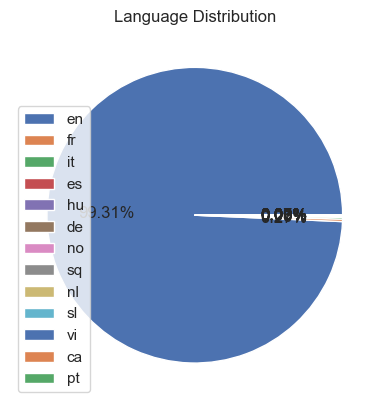

In [12]:
plt.pie(train.Language.value_counts().values.tolist(),autopct='%.2f%%')
plt.legend(labels=train.Language.value_counts().index.tolist(),loc='lower left')
plt.title('Language Distribution')
plt.show()

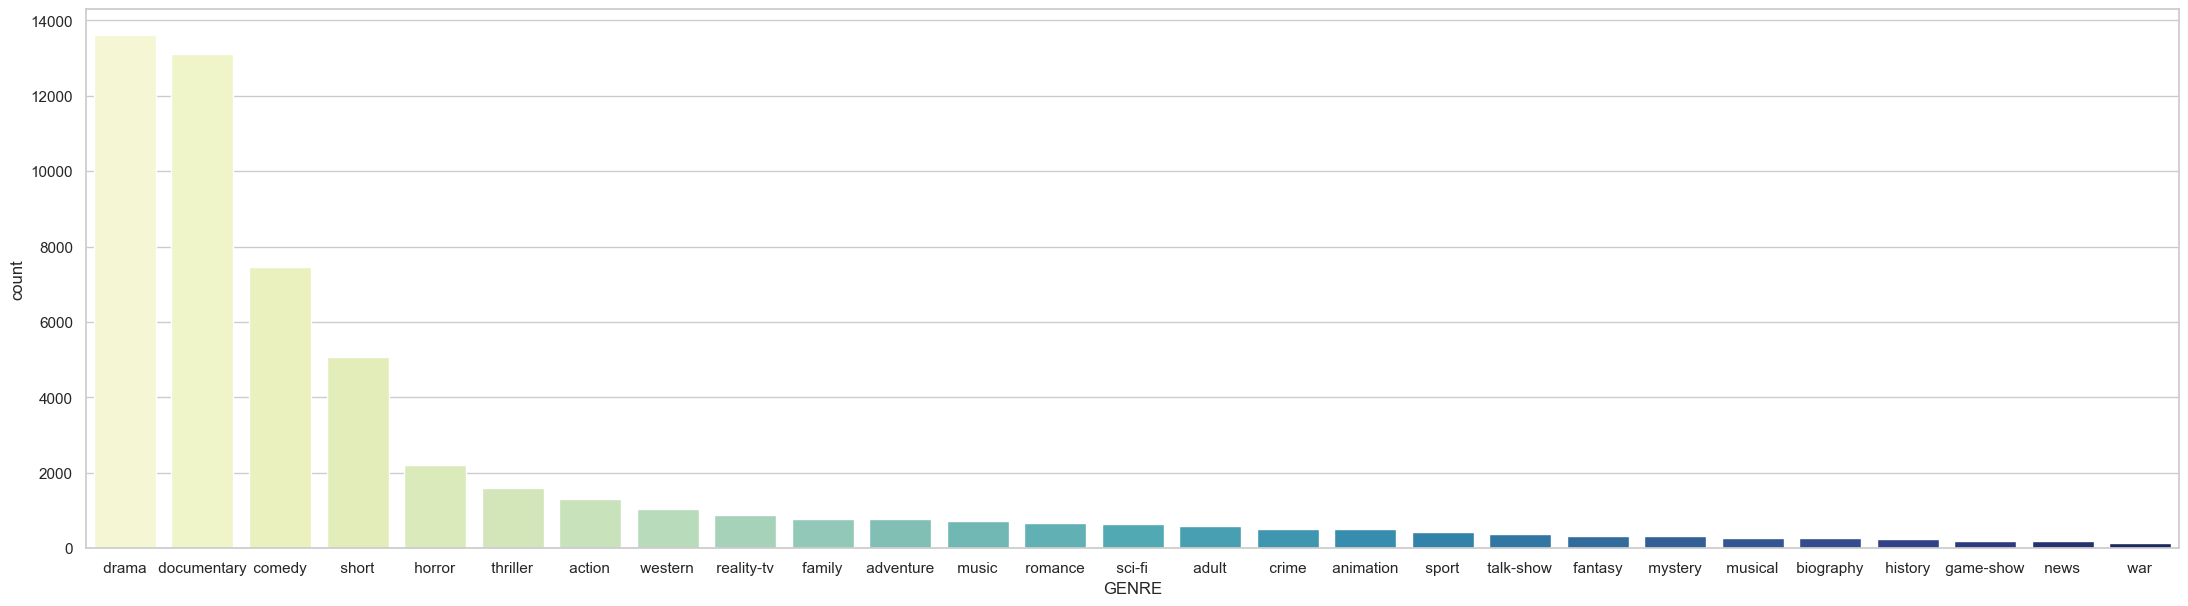

In [13]:
plt.figure(figsize=(27,7))
sns.countplot(data=train, x="GENRE", order= train["GENRE"].value_counts().index, palette = "YlGnBu")
plt.show()

In [14]:
train["Language"].value_counts()

en    53840
fr      145
it      109
es       42
hu       37
de       18
no       17
sq        1
nl        1
sl        1
vi        1
ca        1
pt        1
Name: Language, dtype: int64

Description are in different languages so I convert it to english. It will the help in increasing the accuracy

## Text Cleaning

In [15]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vigne\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
import re
import string
from nltk.corpus import stopwords
import nltk
stopwd = stopwords.words('english')
def clean_text(text):
    
    text= text.lower() # Lowercasing the text
    text = re.sub('Mail <svaradi@sprynet.com> for translation. ', '', text) # Removing unknown mail
    text = re.sub('-',' ',text.lower())   # Replacing `x-x` as `x x`
    text = re.sub(r'@\S+', '', text) # Removing mentions
    text = re.sub(r'http\S+', '', text) # Removing Links
    text = re.sub(f'[{string.punctuation}]', '', text) # Remove punctuations
    text = re.sub(f'[{string.digits}]', '', text) # Remove numbers
    text = re.sub(r'\s+', ' ', text) # Removing unnecessary spaces
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text) # Removing single characters
    
    words = nltk.tokenize.word_tokenize(text,language="english", preserve_line=True)
    text = " ".join([i for i in words if i not in stopwd and len(i)>2]) # Removing the stop words

    return text.strip()

In [17]:
clean_text(train["DESCRIPTION"][0])

'listening conversation doctor parents year old oscar learns nobody courage tell weeks live furious refuses speak anyone except straight talking rose lady pink meets hospital stairs christmas approaches rose uses fantastical experiences professional wrestler imagination wit charm allow oscar live life love full company friends pop corn einstein bacon childhood sweetheart peggy blue'

In [18]:
# applying clean text to train and test
train["clean_description"]=train["DESCRIPTION"].apply(clean_text)
test["clean_description"]=test["DESCRIPTION"].apply(clean_text)

In [19]:
train.head(5)["clean_description"]

0    listening conversation doctor parents year old...
1    brother sister past incestuous relationship cu...
2    bus empties students field trip museum natural...
3    help unemployed father make ends meet edith tw...
4    films title refers recovered bodies ground zer...
Name: clean_description, dtype: object

### Checking the description of lengths of description before and after cleaning

In [20]:
train["len_desc"] = train["DESCRIPTION"].apply(len)
train["len_clean_desc"] = train["clean_description"].apply(len)

In [21]:
train.sample(5)

TITLE          GENRE  \
49699                                 When I Die (2005)    documentary    
53512        The True Story of Richard the Third (????)      biography    
19270                                  Tease Me! (2012)          adult    
33388   Bring the Wing: Long Island Buffalo Wing Fest...   documentary    
9658                     Ice Age 2: The Meltdown (2006)         action    

                                             DESCRIPTION Language  \
49699   "When I Die" is about the making of the Gonzo...       en   
53512   Richard the Third wasn't a hunchback or the e...       en   
19270   A candid reality style film, Tease Me feature...       en   
33388   Bring The Wing made it up to Bay Shore, NY fo...       en   
9658    This game is a spin-off of the film Ice Age: ...       en   

                                       clean_description  len_desc  \
49699  die making gonzo monument hunter thompson blas...       739   
53512  richard third wasnt hunchback evil villain sha...       305   
19270  candid reality style film tease features playf...       246   
33388  bring wing made bay shore first ever long isla...       344   
9658   game spin film ice age meltdown seen eyes scra...       670   

       len_clean_desc  
49699             474  
53512             221  
19270             193  
33388             263  
9658              395

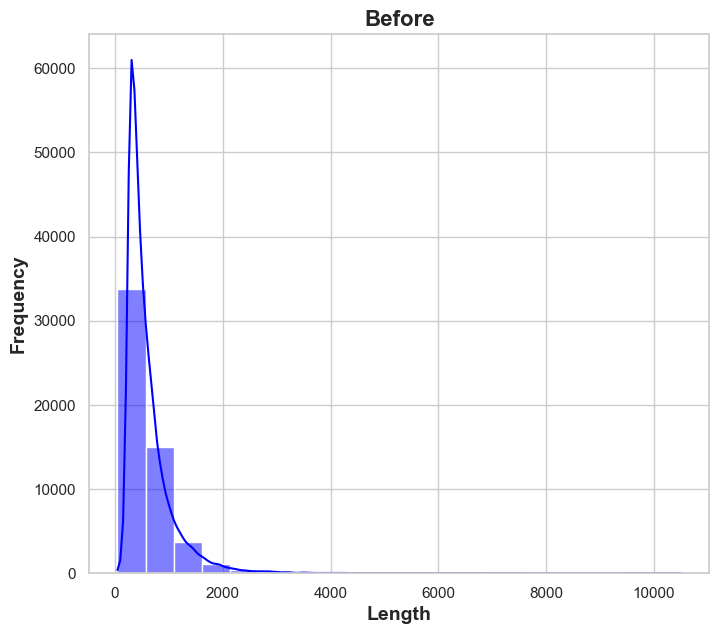

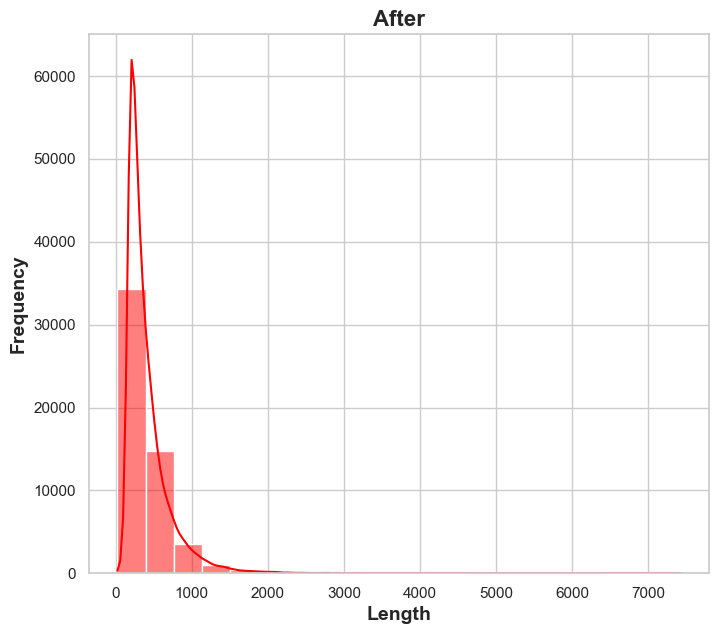

In [22]:
plt.figure(figsize=(8, 7))
sns.histplot(data=train, x='len_desc', bins=20, kde=True, color='blue')
plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Before', fontsize=16, fontweight='bold')
plt.show()

plt.figure(figsize=(8, 7))
sns.histplot(data=train, x='len_clean_desc', bins=20, kde=True, color='red')
plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('After', fontsize=16, fontweight='bold')

plt.show()


In [23]:
#finding the number of descriptions with length greater than 2000
(train["len_clean_desc"]>2000).value_counts()

False    54012
True       202
Name: len_clean_desc, dtype: int64

In [24]:
# if length of description is greater 2000, we will truncate it randomly from 250 to 2000 because most of the description is less than 1500
train["clean_description"] = train["clean_description"].apply(lambda x: x[:np.random.randint(250,2000)] if len(x)>2000 else x)

In [25]:
#finding the number of descriptions with length greater than 2000
train["len_clean_desc"] = train["clean_description"].apply(len)
(train["len_clean_desc"]>2000).value_counts()

False    54214
Name: len_clean_desc, dtype: int64

In [26]:
!pip install deep_translator


In [27]:
from deep_translator import GoogleTranslator
translator = GoogleTranslator()
# translating the description to english if language is not english
def trans(text):
    try: 
        return translator.translate(text)
    except Exception as e:
        return text
    
train["clean_description"] = train.apply(lambda x: trans(x["clean_description"]) if x['Language']!='en' else x['clean_description'],axis=1)

In [28]:
train[train["Language"]!="en"].iloc[0]

TITLE                                  Divorzio alla siciliana (1963) 
GENRE                                                          comedy 
DESCRIPTION           Il barone Fifě ha bisogno di un erede per ave...
Language                                                            it
clean_description    Baron Fifě needs an heir to have his father's ...
len_desc                                                           645
len_clean_desc                                                     518
Name: 210, dtype: object

In [29]:
detect_language(train[train["Language"]!="en"].iloc[0]["clean_description"])

108429


'en'

In [30]:
!pip install spacy


In [31]:
!python -m spacy download en_core_web_sm


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.2/12.8 MB 3.5 MB/s eta 0:00:04
     - -------------------------------------- 0.5/12.8 MB 5.6 MB/s eta 0:00:03
     -- ------------------------------------- 0.9/12.8 MB 6.4 MB/s eta 0:00:02
     --- ------------------------------------ 1.1/12.8 MB 5.8 MB/s eta 0:00:03
     --- ------------------------------------ 1.2/12.8 MB 5.6 MB/s eta 0:00:03
     --- ------------------------------------ 1.2/12.8 MB 5.6 MB/s eta 0:00:03
     --- ------------------------------------ 1.2/12.8 MB 5.6 MB/s eta 0:00:03
     ----- ---------------------------------- 1.8/12.8 MB 4.8 MB/s eta 0:00:03
     ------ --------------------------------- 2.0/12.8 MB 4.8 MB/s eta 0:00:03
     ------ --------------------------------- 2.2/12.8 MB 4.7 MB/s eta 0:00:03
     ------- -------------------------------- 2.4/12.8 MB 4.6 MB/s eta 0:00:03
     -------- ------------------------------- 2.6/12.8 MB 4

In [32]:
import spacy
nlp = spacy.load("en_core_web_sm")
lam_cnt = 0 
def lametize(text):

    #for tracking the progress
    global lam_cnt
    lam_cnt=lam_cnt+1
    print(lam_cnt)
    

    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [33]:
train["clean_description"] = train["clean_description"].apply(lambda x: lametize(x))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065


3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704


5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356


6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002


8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642


10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
1024

11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
1161

12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
12967
12968
12969
12970
12971
12972
12973
12974
12975
12976
12977
12978
12979
12980
12981
12982
12983
12984
12985
12986
12987
12988
12989
12990
12991
1299

14203
14204
14205
14206
14207
14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
14231
14232
14233
14234
14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346
14347
14348
14349
14350
14351
14352
14353
14354
14355
14356
14357
14358
14359
14360
14361
14362
14363
14364
14365
14366
14367
14368
1436

15578
15579
15580
15581
15582
15583
15584
15585
15586
15587
15588
15589
15590
15591
15592
15593
15594
15595
15596
15597
15598
15599
15600
15601
15602
15603
15604
15605
15606
15607
15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
15689
15690
15691
15692
15693
15694
15695
15696
15697
15698
15699
15700
15701
15702
15703
15704
15705
15706
15707
15708
15709
15710
15711
15712
15713
15714
15715
15716
15717
15718
15719
15720
15721
15722
15723
15724
15725
15726
15727
15728
15729
15730
15731
15732
15733
15734
15735
15736
15737
15738
15739
15740
15741
15742
15743
1574

16951
16952
16953
16954
16955
16956
16957
16958
16959
16960
16961
16962
16963
16964
16965
16966
16967
16968
16969
16970
16971
16972
16973
16974
16975
16976
16977
16978
16979
16980
16981
16982
16983
16984
16985
16986
16987
16988
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
17053
17054
17055
17056
17057
17058
17059
17060
17061
17062
17063
17064
17065
17066
17067
17068
17069
17070
17071
17072
17073
17074
17075
17076
17077
17078
17079
17080
17081
17082
17083
17084
17085
17086
17087
17088
17089
17090
17091
17092
17093
17094
17095
17096
17097
17098
17099
17100
17101
17102
17103
17104
17105
17106
17107
17108
17109
17110
17111
17112
17113
17114
17115
17116
1711

18333
18334
18335
18336
18337
18338
18339
18340
18341
18342
18343
18344
18345
18346
18347
18348
18349
18350
18351
18352
18353
18354
18355
18356
18357
18358
18359
18360
18361
18362
18363
18364
18365
18366
18367
18368
18369
18370
18371
18372
18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
18409
18410
18411
18412
18413
18414
18415
18416
18417
18418
18419
18420
18421
18422
18423
18424
18425
18426
18427
18428
18429
18430
18431
18432
18433
18434
18435
18436
18437
18438
18439
18440
18441
18442
18443
18444
18445
18446
18447
18448
18449
18450
18451
18452
18453
18454
18455
18456
18457
18458
18459
18460
18461
18462
18463
18464
18465
18466
18467
18468
18469
18470
18471
18472
18473
18474
18475
18476
18477
18478
18479
18480
18481
18482
18483
18484
18485
18486
18487
18488
18489
18490
18491
18492
18493
18494
18495
18496
18497
18498
1849

19711
19712
19713
19714
19715
19716
19717
19718
19719
19720
19721
19722
19723
19724
19725
19726
19727
19728
19729
19730
19731
19732
19733
19734
19735
19736
19737
19738
19739
19740
19741
19742
19743
19744
19745
19746
19747
19748
19749
19750
19751
19752
19753
19754
19755
19756
19757
19758
19759
19760
19761
19762
19763
19764
19765
19766
19767
19768
19769
19770
19771
19772
19773
19774
19775
19776
19777
19778
19779
19780
19781
19782
19783
19784
19785
19786
19787
19788
19789
19790
19791
19792
19793
19794
19795
19796
19797
19798
19799
19800
19801
19802
19803
19804
19805
19806
19807
19808
19809
19810
19811
19812
19813
19814
19815
19816
19817
19818
19819
19820
19821
19822
19823
19824
19825
19826
19827
19828
19829
19830
19831
19832
19833
19834
19835
19836
19837
19838
19839
19840
19841
19842
19843
19844
19845
19846
19847
19848
19849
19850
19851
19852
19853
19854
19855
19856
19857
19858
19859
19860
19861
19862
19863
19864
19865
19866
19867
19868
19869
19870
19871
19872
19873
19874
19875
19876
1987

21095
21096
21097
21098
21099
21100
21101
21102
21103
21104
21105
21106
21107
21108
21109
21110
21111
21112
21113
21114
21115
21116
21117
21118
21119
21120
21121
21122
21123
21124
21125
21126
21127
21128
21129
21130
21131
21132
21133
21134
21135
21136
21137
21138
21139
21140
21141
21142
21143
21144
21145
21146
21147
21148
21149
21150
21151
21152
21153
21154
21155
21156
21157
21158
21159
21160
21161
21162
21163
21164
21165
21166
21167
21168
21169
21170
21171
21172
21173
21174
21175
21176
21177
21178
21179
21180
21181
21182
21183
21184
21185
21186
21187
21188
21189
21190
21191
21192
21193
21194
21195
21196
21197
21198
21199
21200
21201
21202
21203
21204
21205
21206
21207
21208
21209
21210
21211
21212
21213
21214
21215
21216
21217
21218
21219
21220
21221
21222
21223
21224
21225
21226
21227
21228
21229
21230
21231
21232
21233
21234
21235
21236
21237
21238
21239
21240
21241
21242
21243
21244
21245
21246
21247
21248
21249
21250
21251
21252
21253
21254
21255
21256
21257
21258
21259
21260
2126

22472
22473
22474
22475
22476
22477
22478
22479
22480
22481
22482
22483
22484
22485
22486
22487
22488
22489
22490
22491
22492
22493
22494
22495
22496
22497
22498
22499
22500
22501
22502
22503
22504
22505
22506
22507
22508
22509
22510
22511
22512
22513
22514
22515
22516
22517
22518
22519
22520
22521
22522
22523
22524
22525
22526
22527
22528
22529
22530
22531
22532
22533
22534
22535
22536
22537
22538
22539
22540
22541
22542
22543
22544
22545
22546
22547
22548
22549
22550
22551
22552
22553
22554
22555
22556
22557
22558
22559
22560
22561
22562
22563
22564
22565
22566
22567
22568
22569
22570
22571
22572
22573
22574
22575
22576
22577
22578
22579
22580
22581
22582
22583
22584
22585
22586
22587
22588
22589
22590
22591
22592
22593
22594
22595
22596
22597
22598
22599
22600
22601
22602
22603
22604
22605
22606
22607
22608
22609
22610
22611
22612
22613
22614
22615
22616
22617
22618
22619
22620
22621
22622
22623
22624
22625
22626
22627
22628
22629
22630
22631
22632
22633
22634
22635
22636
22637
2263

23849
23850
23851
23852
23853
23854
23855
23856
23857
23858
23859
23860
23861
23862
23863
23864
23865
23866
23867
23868
23869
23870
23871
23872
23873
23874
23875
23876
23877
23878
23879
23880
23881
23882
23883
23884
23885
23886
23887
23888
23889
23890
23891
23892
23893
23894
23895
23896
23897
23898
23899
23900
23901
23902
23903
23904
23905
23906
23907
23908
23909
23910
23911
23912
23913
23914
23915
23916
23917
23918
23919
23920
23921
23922
23923
23924
23925
23926
23927
23928
23929
23930
23931
23932
23933
23934
23935
23936
23937
23938
23939
23940
23941
23942
23943
23944
23945
23946
23947
23948
23949
23950
23951
23952
23953
23954
23955
23956
23957
23958
23959
23960
23961
23962
23963
23964
23965
23966
23967
23968
23969
23970
23971
23972
23973
23974
23975
23976
23977
23978
23979
23980
23981
23982
23983
23984
23985
23986
23987
23988
23989
23990
23991
23992
23993
23994
23995
23996
23997
23998
23999
24000
24001
24002
24003
24004
24005
24006
24007
24008
24009
24010
24011
24012
24013
24014
2401

25219
25220
25221
25222
25223
25224
25225
25226
25227
25228
25229
25230
25231
25232
25233
25234
25235
25236
25237
25238
25239
25240
25241
25242
25243
25244
25245
25246
25247
25248
25249
25250
25251
25252
25253
25254
25255
25256
25257
25258
25259
25260
25261
25262
25263
25264
25265
25266
25267
25268
25269
25270
25271
25272
25273
25274
25275
25276
25277
25278
25279
25280
25281
25282
25283
25284
25285
25286
25287
25288
25289
25290
25291
25292
25293
25294
25295
25296
25297
25298
25299
25300
25301
25302
25303
25304
25305
25306
25307
25308
25309
25310
25311
25312
25313
25314
25315
25316
25317
25318
25319
25320
25321
25322
25323
25324
25325
25326
25327
25328
25329
25330
25331
25332
25333
25334
25335
25336
25337
25338
25339
25340
25341
25342
25343
25344
25345
25346
25347
25348
25349
25350
25351
25352
25353
25354
25355
25356
25357
25358
25359
25360
25361
25362
25363
25364
25365
25366
25367
25368
25369
25370
25371
25372
25373
25374
25375
25376
25377
25378
25379
25380
25381
25382
25383
25384
2538

26597
26598
26599
26600
26601
26602
26603
26604
26605
26606
26607
26608
26609
26610
26611
26612
26613
26614
26615
26616
26617
26618
26619
26620
26621
26622
26623
26624
26625
26626
26627
26628
26629
26630
26631
26632
26633
26634
26635
26636
26637
26638
26639
26640
26641
26642
26643
26644
26645
26646
26647
26648
26649
26650
26651
26652
26653
26654
26655
26656
26657
26658
26659
26660
26661
26662
26663
26664
26665
26666
26667
26668
26669
26670
26671
26672
26673
26674
26675
26676
26677
26678
26679
26680
26681
26682
26683
26684
26685
26686
26687
26688
26689
26690
26691
26692
26693
26694
26695
26696
26697
26698
26699
26700
26701
26702
26703
26704
26705
26706
26707
26708
26709
26710
26711
26712
26713
26714
26715
26716
26717
26718
26719
26720
26721
26722
26723
26724
26725
26726
26727
26728
26729
26730
26731
26732
26733
26734
26735
26736
26737
26738
26739
26740
26741
26742
26743
26744
26745
26746
26747
26748
26749
26750
26751
26752
26753
26754
26755
26756
26757
26758
26759
26760
26761
26762
2676

27979
27980
27981
27982
27983
27984
27985
27986
27987
27988
27989
27990
27991
27992
27993
27994
27995
27996
27997
27998
27999
28000
28001
28002
28003
28004
28005
28006
28007
28008
28009
28010
28011
28012
28013
28014
28015
28016
28017
28018
28019
28020
28021
28022
28023
28024
28025
28026
28027
28028
28029
28030
28031
28032
28033
28034
28035
28036
28037
28038
28039
28040
28041
28042
28043
28044
28045
28046
28047
28048
28049
28050
28051
28052
28053
28054
28055
28056
28057
28058
28059
28060
28061
28062
28063
28064
28065
28066
28067
28068
28069
28070
28071
28072
28073
28074
28075
28076
28077
28078
28079
28080
28081
28082
28083
28084
28085
28086
28087
28088
28089
28090
28091
28092
28093
28094
28095
28096
28097
28098
28099
28100
28101
28102
28103
28104
28105
28106
28107
28108
28109
28110
28111
28112
28113
28114
28115
28116
28117
28118
28119
28120
28121
28122
28123
28124
28125
28126
28127
28128
28129
28130
28131
28132
28133
28134
28135
28136
28137
28138
28139
28140
28141
28142
28143
28144
2814

29362
29363
29364
29365
29366
29367
29368
29369
29370
29371
29372
29373
29374
29375
29376
29377
29378
29379
29380
29381
29382
29383
29384
29385
29386
29387
29388
29389
29390
29391
29392
29393
29394
29395
29396
29397
29398
29399
29400
29401
29402
29403
29404
29405
29406
29407
29408
29409
29410
29411
29412
29413
29414
29415
29416
29417
29418
29419
29420
29421
29422
29423
29424
29425
29426
29427
29428
29429
29430
29431
29432
29433
29434
29435
29436
29437
29438
29439
29440
29441
29442
29443
29444
29445
29446
29447
29448
29449
29450
29451
29452
29453
29454
29455
29456
29457
29458
29459
29460
29461
29462
29463
29464
29465
29466
29467
29468
29469
29470
29471
29472
29473
29474
29475
29476
29477
29478
29479
29480
29481
29482
29483
29484
29485
29486
29487
29488
29489
29490
29491
29492
29493
29494
29495
29496
29497
29498
29499
29500
29501
29502
29503
29504
29505
29506
29507
29508
29509
29510
29511
29512
29513
29514
29515
29516
29517
29518
29519
29520
29521
29522
29523
29524
29525
29526
29527
2952

30737
30738
30739
30740
30741
30742
30743
30744
30745
30746
30747
30748
30749
30750
30751
30752
30753
30754
30755
30756
30757
30758
30759
30760
30761
30762
30763
30764
30765
30766
30767
30768
30769
30770
30771
30772
30773
30774
30775
30776
30777
30778
30779
30780
30781
30782
30783
30784
30785
30786
30787
30788
30789
30790
30791
30792
30793
30794
30795
30796
30797
30798
30799
30800
30801
30802
30803
30804
30805
30806
30807
30808
30809
30810
30811
30812
30813
30814
30815
30816
30817
30818
30819
30820
30821
30822
30823
30824
30825
30826
30827
30828
30829
30830
30831
30832
30833
30834
30835
30836
30837
30838
30839
30840
30841
30842
30843
30844
30845
30846
30847
30848
30849
30850
30851
30852
30853
30854
30855
30856
30857
30858
30859
30860
30861
30862
30863
30864
30865
30866
30867
30868
30869
30870
30871
30872
30873
30874
30875
30876
30877
30878
30879
30880
30881
30882
30883
30884
30885
30886
30887
30888
30889
30890
30891
30892
30893
30894
30895
30896
30897
30898
30899
30900
30901
30902
3090

32104
32105
32106
32107
32108
32109
32110
32111
32112
32113
32114
32115
32116
32117
32118
32119
32120
32121
32122
32123
32124
32125
32126
32127
32128
32129
32130
32131
32132
32133
32134
32135
32136
32137
32138
32139
32140
32141
32142
32143
32144
32145
32146
32147
32148
32149
32150
32151
32152
32153
32154
32155
32156
32157
32158
32159
32160
32161
32162
32163
32164
32165
32166
32167
32168
32169
32170
32171
32172
32173
32174
32175
32176
32177
32178
32179
32180
32181
32182
32183
32184
32185
32186
32187
32188
32189
32190
32191
32192
32193
32194
32195
32196
32197
32198
32199
32200
32201
32202
32203
32204
32205
32206
32207
32208
32209
32210
32211
32212
32213
32214
32215
32216
32217
32218
32219
32220
32221
32222
32223
32224
32225
32226
32227
32228
32229
32230
32231
32232
32233
32234
32235
32236
32237
32238
32239
32240
32241
32242
32243
32244
32245
32246
32247
32248
32249
32250
32251
32252
32253
32254
32255
32256
32257
32258
32259
32260
32261
32262
32263
32264
32265
32266
32267
32268
32269
3227

33478
33479
33480
33481
33482
33483
33484
33485
33486
33487
33488
33489
33490
33491
33492
33493
33494
33495
33496
33497
33498
33499
33500
33501
33502
33503
33504
33505
33506
33507
33508
33509
33510
33511
33512
33513
33514
33515
33516
33517
33518
33519
33520
33521
33522
33523
33524
33525
33526
33527
33528
33529
33530
33531
33532
33533
33534
33535
33536
33537
33538
33539
33540
33541
33542
33543
33544
33545
33546
33547
33548
33549
33550
33551
33552
33553
33554
33555
33556
33557
33558
33559
33560
33561
33562
33563
33564
33565
33566
33567
33568
33569
33570
33571
33572
33573
33574
33575
33576
33577
33578
33579
33580
33581
33582
33583
33584
33585
33586
33587
33588
33589
33590
33591
33592
33593
33594
33595
33596
33597
33598
33599
33600
33601
33602
33603
33604
33605
33606
33607
33608
33609
33610
33611
33612
33613
33614
33615
33616
33617
33618
33619
33620
33621
33622
33623
33624
33625
33626
33627
33628
33629
33630
33631
33632
33633
33634
33635
33636
33637
33638
33639
33640
33641
33642
33643
3364

34854
34855
34856
34857
34858
34859
34860
34861
34862
34863
34864
34865
34866
34867
34868
34869
34870
34871
34872
34873
34874
34875
34876
34877
34878
34879
34880
34881
34882
34883
34884
34885
34886
34887
34888
34889
34890
34891
34892
34893
34894
34895
34896
34897
34898
34899
34900
34901
34902
34903
34904
34905
34906
34907
34908
34909
34910
34911
34912
34913
34914
34915
34916
34917
34918
34919
34920
34921
34922
34923
34924
34925
34926
34927
34928
34929
34930
34931
34932
34933
34934
34935
34936
34937
34938
34939
34940
34941
34942
34943
34944
34945
34946
34947
34948
34949
34950
34951
34952
34953
34954
34955
34956
34957
34958
34959
34960
34961
34962
34963
34964
34965
34966
34967
34968
34969
34970
34971
34972
34973
34974
34975
34976
34977
34978
34979
34980
34981
34982
34983
34984
34985
34986
34987
34988
34989
34990
34991
34992
34993
34994
34995
34996
34997
34998
34999
35000
35001
35002
35003
35004
35005
35006
35007
35008
35009
35010
35011
35012
35013
35014
35015
35016
35017
35018
35019
3502

36228
36229
36230
36231
36232
36233
36234
36235
36236
36237
36238
36239
36240
36241
36242
36243
36244
36245
36246
36247
36248
36249
36250
36251
36252
36253
36254
36255
36256
36257
36258
36259
36260
36261
36262
36263
36264
36265
36266
36267
36268
36269
36270
36271
36272
36273
36274
36275
36276
36277
36278
36279
36280
36281
36282
36283
36284
36285
36286
36287
36288
36289
36290
36291
36292
36293
36294
36295
36296
36297
36298
36299
36300
36301
36302
36303
36304
36305
36306
36307
36308
36309
36310
36311
36312
36313
36314
36315
36316
36317
36318
36319
36320
36321
36322
36323
36324
36325
36326
36327
36328
36329
36330
36331
36332
36333
36334
36335
36336
36337
36338
36339
36340
36341
36342
36343
36344
36345
36346
36347
36348
36349
36350
36351
36352
36353
36354
36355
36356
36357
36358
36359
36360
36361
36362
36363
36364
36365
36366
36367
36368
36369
36370
36371
36372
36373
36374
36375
36376
36377
36378
36379
36380
36381
36382
36383
36384
36385
36386
36387
36388
36389
36390
36391
36392
36393
3639

37600
37601
37602
37603
37604
37605
37606
37607
37608
37609
37610
37611
37612
37613
37614
37615
37616
37617
37618
37619
37620
37621
37622
37623
37624
37625
37626
37627
37628
37629
37630
37631
37632
37633
37634
37635
37636
37637
37638
37639
37640
37641
37642
37643
37644
37645
37646
37647
37648
37649
37650
37651
37652
37653
37654
37655
37656
37657
37658
37659
37660
37661
37662
37663
37664
37665
37666
37667
37668
37669
37670
37671
37672
37673
37674
37675
37676
37677
37678
37679
37680
37681
37682
37683
37684
37685
37686
37687
37688
37689
37690
37691
37692
37693
37694
37695
37696
37697
37698
37699
37700
37701
37702
37703
37704
37705
37706
37707
37708
37709
37710
37711
37712
37713
37714
37715
37716
37717
37718
37719
37720
37721
37722
37723
37724
37725
37726
37727
37728
37729
37730
37731
37732
37733
37734
37735
37736
37737
37738
37739
37740
37741
37742
37743
37744
37745
37746
37747
37748
37749
37750
37751
37752
37753
37754
37755
37756
37757
37758
37759
37760
37761
37762
37763
37764
37765
3776

38968
38969
38970
38971
38972
38973
38974
38975
38976
38977
38978
38979
38980
38981
38982
38983
38984
38985
38986
38987
38988
38989
38990
38991
38992
38993
38994
38995
38996
38997
38998
38999
39000
39001
39002
39003
39004
39005
39006
39007
39008
39009
39010
39011
39012
39013
39014
39015
39016
39017
39018
39019
39020
39021
39022
39023
39024
39025
39026
39027
39028
39029
39030
39031
39032
39033
39034
39035
39036
39037
39038
39039
39040
39041
39042
39043
39044
39045
39046
39047
39048
39049
39050
39051
39052
39053
39054
39055
39056
39057
39058
39059
39060
39061
39062
39063
39064
39065
39066
39067
39068
39069
39070
39071
39072
39073
39074
39075
39076
39077
39078
39079
39080
39081
39082
39083
39084
39085
39086
39087
39088
39089
39090
39091
39092
39093
39094
39095
39096
39097
39098
39099
39100
39101
39102
39103
39104
39105
39106
39107
39108
39109
39110
39111
39112
39113
39114
39115
39116
39117
39118
39119
39120
39121
39122
39123
39124
39125
39126
39127
39128
39129
39130
39131
39132
39133
3913

40347
40348
40349
40350
40351
40352
40353
40354
40355
40356
40357
40358
40359
40360
40361
40362
40363
40364
40365
40366
40367
40368
40369
40370
40371
40372
40373
40374
40375
40376
40377
40378
40379
40380
40381
40382
40383
40384
40385
40386
40387
40388
40389
40390
40391
40392
40393
40394
40395
40396
40397
40398
40399
40400
40401
40402
40403
40404
40405
40406
40407
40408
40409
40410
40411
40412
40413
40414
40415
40416
40417
40418
40419
40420
40421
40422
40423
40424
40425
40426
40427
40428
40429
40430
40431
40432
40433
40434
40435
40436
40437
40438
40439
40440
40441
40442
40443
40444
40445
40446
40447
40448
40449
40450
40451
40452
40453
40454
40455
40456
40457
40458
40459
40460
40461
40462
40463
40464
40465
40466
40467
40468
40469
40470
40471
40472
40473
40474
40475
40476
40477
40478
40479
40480
40481
40482
40483
40484
40485
40486
40487
40488
40489
40490
40491
40492
40493
40494
40495
40496
40497
40498
40499
40500
40501
40502
40503
40504
40505
40506
40507
40508
40509
40510
40511
40512
4051

41713
41714
41715
41716
41717
41718
41719
41720
41721
41722
41723
41724
41725
41726
41727
41728
41729
41730
41731
41732
41733
41734
41735
41736
41737
41738
41739
41740
41741
41742
41743
41744
41745
41746
41747
41748
41749
41750
41751
41752
41753
41754
41755
41756
41757
41758
41759
41760
41761
41762
41763
41764
41765
41766
41767
41768
41769
41770
41771
41772
41773
41774
41775
41776
41777
41778
41779
41780
41781
41782
41783
41784
41785
41786
41787
41788
41789
41790
41791
41792
41793
41794
41795
41796
41797
41798
41799
41800
41801
41802
41803
41804
41805
41806
41807
41808
41809
41810
41811
41812
41813
41814
41815
41816
41817
41818
41819
41820
41821
41822
41823
41824
41825
41826
41827
41828
41829
41830
41831
41832
41833
41834
41835
41836
41837
41838
41839
41840
41841
41842
41843
41844
41845
41846
41847
41848
41849
41850
41851
41852
41853
41854
41855
41856
41857
41858
41859
41860
41861
41862
41863
41864
41865
41866
41867
41868
41869
41870
41871
41872
41873
41874
41875
41876
41877
41878
4187

43092
43093
43094
43095
43096
43097
43098
43099
43100
43101
43102
43103
43104
43105
43106
43107
43108
43109
43110
43111
43112
43113
43114
43115
43116
43117
43118
43119
43120
43121
43122
43123
43124
43125
43126
43127
43128
43129
43130
43131
43132
43133
43134
43135
43136
43137
43138
43139
43140
43141
43142
43143
43144
43145
43146
43147
43148
43149
43150
43151
43152
43153
43154
43155
43156
43157
43158
43159
43160
43161
43162
43163
43164
43165
43166
43167
43168
43169
43170
43171
43172
43173
43174
43175
43176
43177
43178
43179
43180
43181
43182
43183
43184
43185
43186
43187
43188
43189
43190
43191
43192
43193
43194
43195
43196
43197
43198
43199
43200
43201
43202
43203
43204
43205
43206
43207
43208
43209
43210
43211
43212
43213
43214
43215
43216
43217
43218
43219
43220
43221
43222
43223
43224
43225
43226
43227
43228
43229
43230
43231
43232
43233
43234
43235
43236
43237
43238
43239
43240
43241
43242
43243
43244
43245
43246
43247
43248
43249
43250
43251
43252
43253
43254
43255
43256
43257
4325

44470
44471
44472
44473
44474
44475
44476
44477
44478
44479
44480
44481
44482
44483
44484
44485
44486
44487
44488
44489
44490
44491
44492
44493
44494
44495
44496
44497
44498
44499
44500
44501
44502
44503
44504
44505
44506
44507
44508
44509
44510
44511
44512
44513
44514
44515
44516
44517
44518
44519
44520
44521
44522
44523
44524
44525
44526
44527
44528
44529
44530
44531
44532
44533
44534
44535
44536
44537
44538
44539
44540
44541
44542
44543
44544
44545
44546
44547
44548
44549
44550
44551
44552
44553
44554
44555
44556
44557
44558
44559
44560
44561
44562
44563
44564
44565
44566
44567
44568
44569
44570
44571
44572
44573
44574
44575
44576
44577
44578
44579
44580
44581
44582
44583
44584
44585
44586
44587
44588
44589
44590
44591
44592
44593
44594
44595
44596
44597
44598
44599
44600
44601
44602
44603
44604
44605
44606
44607
44608
44609
44610
44611
44612
44613
44614
44615
44616
44617
44618
44619
44620
44621
44622
44623
44624
44625
44626
44627
44628
44629
44630
44631
44632
44633
44634
44635
4463

45839
45840
45841
45842
45843
45844
45845
45846
45847
45848
45849
45850
45851
45852
45853
45854
45855
45856
45857
45858
45859
45860
45861
45862
45863
45864
45865
45866
45867
45868
45869
45870
45871
45872
45873
45874
45875
45876
45877
45878
45879
45880
45881
45882
45883
45884
45885
45886
45887
45888
45889
45890
45891
45892
45893
45894
45895
45896
45897
45898
45899
45900
45901
45902
45903
45904
45905
45906
45907
45908
45909
45910
45911
45912
45913
45914
45915
45916
45917
45918
45919
45920
45921
45922
45923
45924
45925
45926
45927
45928
45929
45930
45931
45932
45933
45934
45935
45936
45937
45938
45939
45940
45941
45942
45943
45944
45945
45946
45947
45948
45949
45950
45951
45952
45953
45954
45955
45956
45957
45958
45959
45960
45961
45962
45963
45964
45965
45966
45967
45968
45969
45970
45971
45972
45973
45974
45975
45976
45977
45978
45979
45980
45981
45982
45983
45984
45985
45986
45987
45988
45989
45990
45991
45992
45993
45994
45995
45996
45997
45998
45999
46000
46001
46002
46003
46004
4600

47215
47216
47217
47218
47219
47220
47221
47222
47223
47224
47225
47226
47227
47228
47229
47230
47231
47232
47233
47234
47235
47236
47237
47238
47239
47240
47241
47242
47243
47244
47245
47246
47247
47248
47249
47250
47251
47252
47253
47254
47255
47256
47257
47258
47259
47260
47261
47262
47263
47264
47265
47266
47267
47268
47269
47270
47271
47272
47273
47274
47275
47276
47277
47278
47279
47280
47281
47282
47283
47284
47285
47286
47287
47288
47289
47290
47291
47292
47293
47294
47295
47296
47297
47298
47299
47300
47301
47302
47303
47304
47305
47306
47307
47308
47309
47310
47311
47312
47313
47314
47315
47316
47317
47318
47319
47320
47321
47322
47323
47324
47325
47326
47327
47328
47329
47330
47331
47332
47333
47334
47335
47336
47337
47338
47339
47340
47341
47342
47343
47344
47345
47346
47347
47348
47349
47350
47351
47352
47353
47354
47355
47356
47357
47358
47359
47360
47361
47362
47363
47364
47365
47366
47367
47368
47369
47370
47371
47372
47373
47374
47375
47376
47377
47378
47379
47380
4738

48583
48584
48585
48586
48587
48588
48589
48590
48591
48592
48593
48594
48595
48596
48597
48598
48599
48600
48601
48602
48603
48604
48605
48606
48607
48608
48609
48610
48611
48612
48613
48614
48615
48616
48617
48618
48619
48620
48621
48622
48623
48624
48625
48626
48627
48628
48629
48630
48631
48632
48633
48634
48635
48636
48637
48638
48639
48640
48641
48642
48643
48644
48645
48646
48647
48648
48649
48650
48651
48652
48653
48654
48655
48656
48657
48658
48659
48660
48661
48662
48663
48664
48665
48666
48667
48668
48669
48670
48671
48672
48673
48674
48675
48676
48677
48678
48679
48680
48681
48682
48683
48684
48685
48686
48687
48688
48689
48690
48691
48692
48693
48694
48695
48696
48697
48698
48699
48700
48701
48702
48703
48704
48705
48706
48707
48708
48709
48710
48711
48712
48713
48714
48715
48716
48717
48718
48719
48720
48721
48722
48723
48724
48725
48726
48727
48728
48729
48730
48731
48732
48733
48734
48735
48736
48737
48738
48739
48740
48741
48742
48743
48744
48745
48746
48747
48748
4874

49951
49952
49953
49954
49955
49956
49957
49958
49959
49960
49961
49962
49963
49964
49965
49966
49967
49968
49969
49970
49971
49972
49973
49974
49975
49976
49977
49978
49979
49980
49981
49982
49983
49984
49985
49986
49987
49988
49989
49990
49991
49992
49993
49994
49995
49996
49997
49998
49999
50000
50001
50002
50003
50004
50005
50006
50007
50008
50009
50010
50011
50012
50013
50014
50015
50016
50017
50018
50019
50020
50021
50022
50023
50024
50025
50026
50027
50028
50029
50030
50031
50032
50033
50034
50035
50036
50037
50038
50039
50040
50041
50042
50043
50044
50045
50046
50047
50048
50049
50050
50051
50052
50053
50054
50055
50056
50057
50058
50059
50060
50061
50062
50063
50064
50065
50066
50067
50068
50069
50070
50071
50072
50073
50074
50075
50076
50077
50078
50079
50080
50081
50082
50083
50084
50085
50086
50087
50088
50089
50090
50091
50092
50093
50094
50095
50096
50097
50098
50099
50100
50101
50102
50103
50104
50105
50106
50107
50108
50109
50110
50111
50112
50113
50114
50115
50116
5011

51320
51321
51322
51323
51324
51325
51326
51327
51328
51329
51330
51331
51332
51333
51334
51335
51336
51337
51338
51339
51340
51341
51342
51343
51344
51345
51346
51347
51348
51349
51350
51351
51352
51353
51354
51355
51356
51357
51358
51359
51360
51361
51362
51363
51364
51365
51366
51367
51368
51369
51370
51371
51372
51373
51374
51375
51376
51377
51378
51379
51380
51381
51382
51383
51384
51385
51386
51387
51388
51389
51390
51391
51392
51393
51394
51395
51396
51397
51398
51399
51400
51401
51402
51403
51404
51405
51406
51407
51408
51409
51410
51411
51412
51413
51414
51415
51416
51417
51418
51419
51420
51421
51422
51423
51424
51425
51426
51427
51428
51429
51430
51431
51432
51433
51434
51435
51436
51437
51438
51439
51440
51441
51442
51443
51444
51445
51446
51447
51448
51449
51450
51451
51452
51453
51454
51455
51456
51457
51458
51459
51460
51461
51462
51463
51464
51465
51466
51467
51468
51469
51470
51471
51472
51473
51474
51475
51476
51477
51478
51479
51480
51481
51482
51483
51484
51485
5148

52694
52695
52696
52697
52698
52699
52700
52701
52702
52703
52704
52705
52706
52707
52708
52709
52710
52711
52712
52713
52714
52715
52716
52717
52718
52719
52720
52721
52722
52723
52724
52725
52726
52727
52728
52729
52730
52731
52732
52733
52734
52735
52736
52737
52738
52739
52740
52741
52742
52743
52744
52745
52746
52747
52748
52749
52750
52751
52752
52753
52754
52755
52756
52757
52758
52759
52760
52761
52762
52763
52764
52765
52766
52767
52768
52769
52770
52771
52772
52773
52774
52775
52776
52777
52778
52779
52780
52781
52782
52783
52784
52785
52786
52787
52788
52789
52790
52791
52792
52793
52794
52795
52796
52797
52798
52799
52800
52801
52802
52803
52804
52805
52806
52807
52808
52809
52810
52811
52812
52813
52814
52815
52816
52817
52818
52819
52820
52821
52822
52823
52824
52825
52826
52827
52828
52829
52830
52831
52832
52833
52834
52835
52836
52837
52838
52839
52840
52841
52842
52843
52844
52845
52846
52847
52848
52849
52850
52851
52852
52853
52854
52855
52856
52857
52858
52859
5286

54078
54079
54080
54081
54082
54083
54084
54085
54086
54087
54088
54089
54090
54091
54092
54093
54094
54095
54096
54097
54098
54099
54100
54101
54102
54103
54104
54105
54106
54107
54108
54109
54110
54111
54112
54113
54114
54115
54116
54117
54118
54119
54120
54121
54122
54123
54124
54125
54126
54127
54128
54129
54130
54131
54132
54133
54134
54135
54136
54137
54138
54139
54140
54141
54142
54143
54144
54145
54146
54147
54148
54149
54150
54151
54152
54153
54154
54155
54156
54157
54158
54159
54160
54161
54162
54163
54164
54165
54166
54167
54168
54169
54170
54171
54172
54173
54174
54175
54176
54177
54178
54179
54180
54181
54182
54183
54184
54185
54186
54187
54188
54189
54190
54191
54192
54193
54194
54195
54196
54197
54198
54199
54200
54201
54202
54203
54204
54205
54206
54207
54208
54209
54210
54211
54212
54213
54214


In [34]:
train.sample(5)

TITLE          GENRE  \
36663                     Tom Brown's Schooldays (1951)          drama    
25846   "The Beaumonts: The Kentucky Bourbon Series" ...         drama    
22879                              What Is ASMR? (2016)    documentary    
36138                    Arai Enn 305-il Kadavul (2008)        fantasy    
47926                         A Hero of Our Time (????)          drama    

                                             DESCRIPTION Language  \
36663   A faithful rendition of the Thomas Hughes boo...       en   
25846   The Beaumonts: The Kentucky Bourbon Series is...       en   
22879   It is the most relaxing thing on the internet...       en   
36138   The story revolves around two unemployed yout...       en   
47926   Our Hero is beaten, tortured, exiled from Sai...       en   

                                       clean_description  len_desc  \
36663  faithful rendition thomas hughes book life fam...       493   
25846  beaumonts kentucky bourbon series highly antic...       350   
22879  relax thing internet entire video culture base...       388   
36138  story revolve around two unemployed youth stru...       616   
47926  hero beat torture exile saint petersburg emper...       628   

       len_clean_desc  
36663             361  
25846             287  
22879             266  
36138             407  
47926             445

In [35]:
train.drop(columns=["len_desc","len_clean_desc","Language","DESCRIPTION"],inplace=True)

### Merging title and Description

In [36]:
train["input"] = train["TITLE"]+" "+train["clean_description"]
test["input"] = test["TITLE"]+" "+test["clean_description"]

## Analysis of the GENRE of movies

In [37]:
train["GENRE"].unique(),train["GENRE"].unique().shape

(array([' drama ', ' thriller ', ' adult ', ' documentary ', ' comedy ',
        ' crime ', ' reality-tv ', ' horror ', ' sport ', ' animation ',
        ' action ', ' fantasy ', ' short ', ' sci-fi ', ' music ',
        ' adventure ', ' talk-show ', ' western ', ' family ', ' mystery ',
        ' history ', ' news ', ' biography ', ' romance ', ' game-show ',
        ' musical ', ' war '], dtype=object),
 (27,))

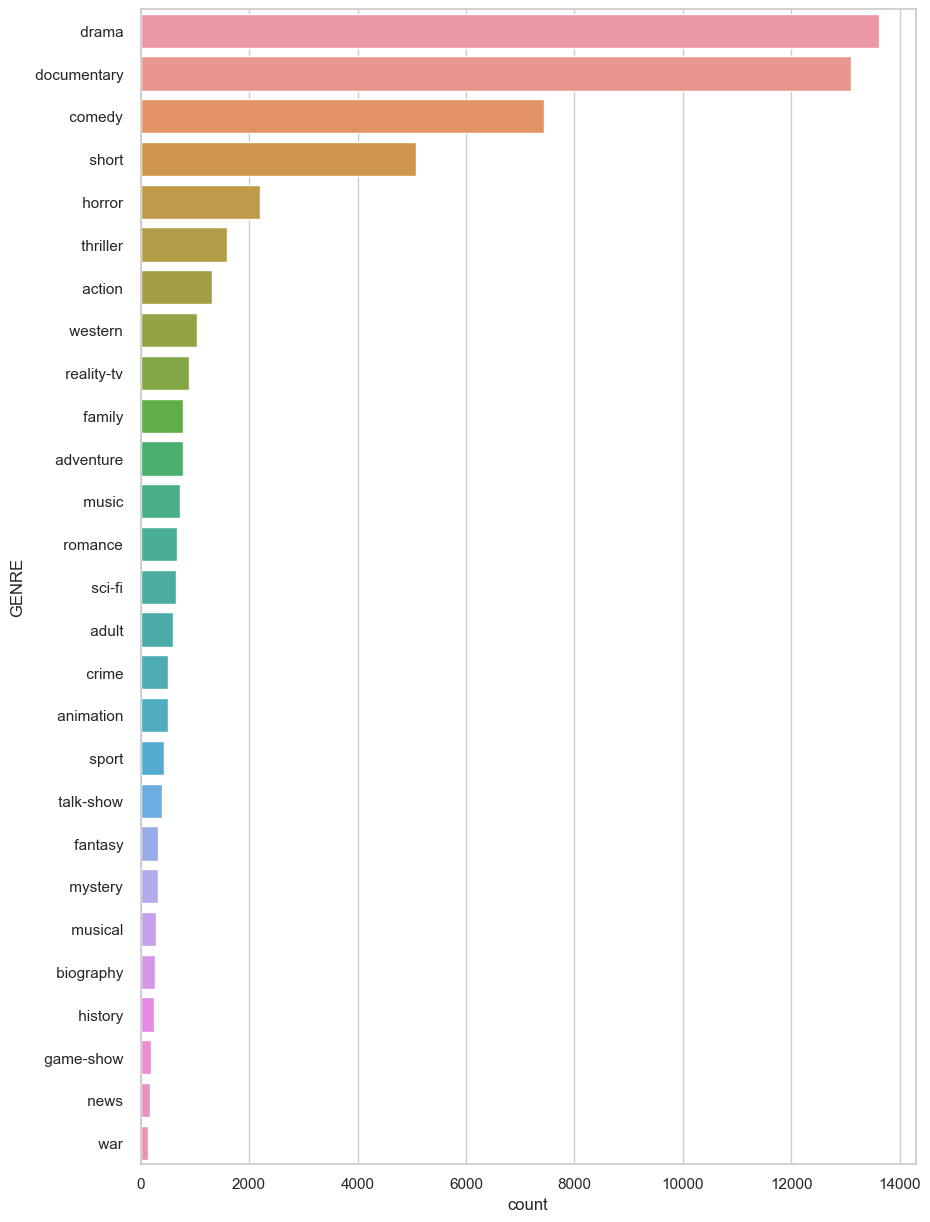

In [38]:
plt.figure(figsize=(10,15))
sns.countplot(data=train, y="GENRE", order= train["GENRE"].value_counts().index)
plt.show()

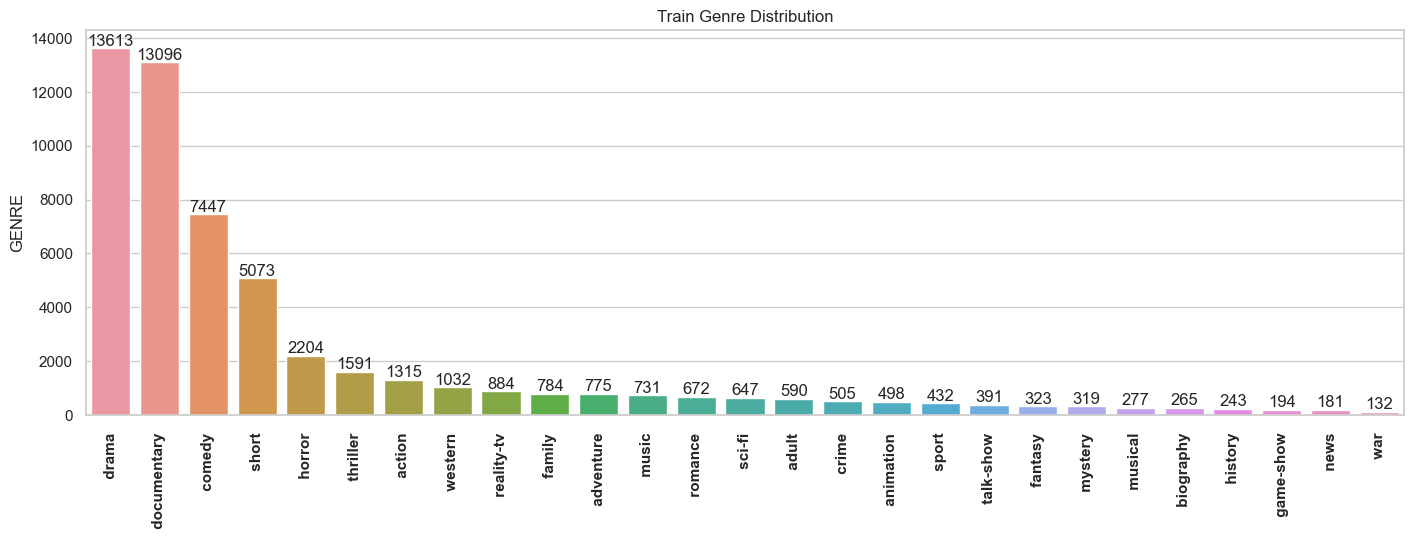

In [39]:
plt.subplots(figsize=(17, 5))
ax1 = sns.barplot(x=train["GENRE"].value_counts().index,
            y=train["GENRE"].value_counts())
ax1.bar_label(ax1.containers[0])
plt.title("Train Genre Distribution")
plt.xticks(rotation=90,fontweight="bold")
plt.show()

#### There is Highly imbalance in training and testing data.

Hence in order to avoid the imbalance I'm going to use random sampler

## Vectorizing using tfidf

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=35000)

In [41]:
X_train_transformed = tfidf.fit_transform(train["input"])
X_test_transformed = tfidf.transform(test["input"])

#### Increasing the data using the random sampler to avoid the imbalance in the class

In [42]:
!pip install --upgrade imbalanced-learn scikit-learn


In [43]:
from imblearn.over_sampling import RandomOverSampler

sampler = RandomOverSampler(random_state=42)
# We will pass to it the output of TfidfVectorizer from train data
x_train_resampled, y_train_resampled = sampler.fit_resample(
    X_train_transformed, train['GENRE'])

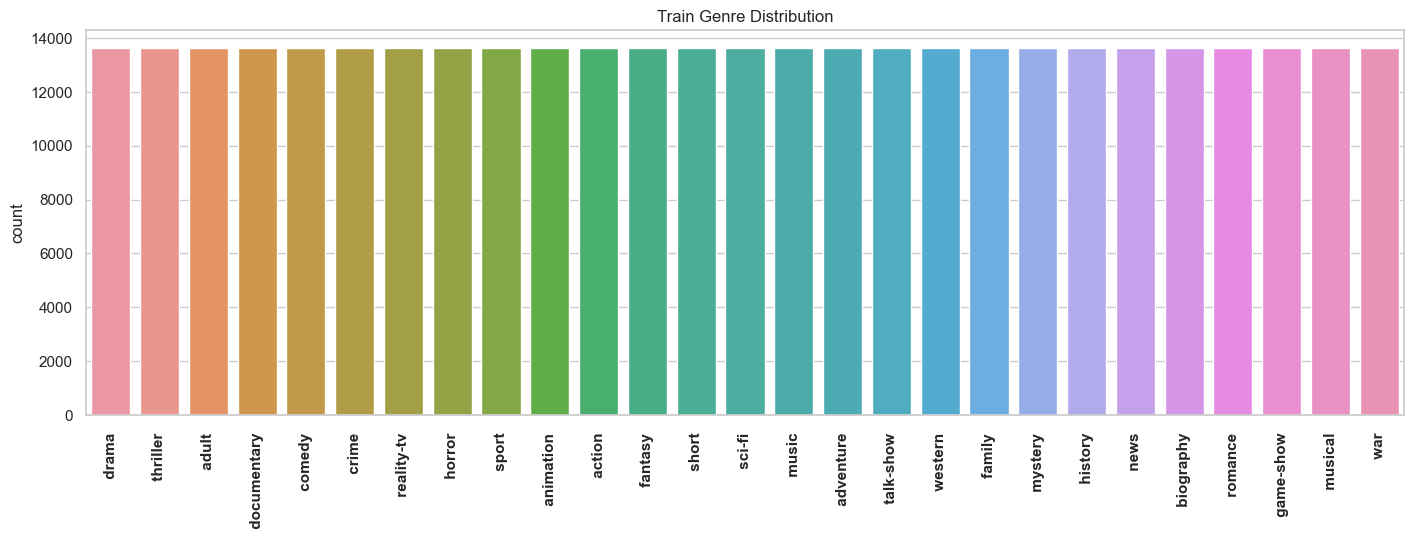

In [44]:
plt.subplots(figsize=(17, 5))
sns.countplot(data=y_train_resampled,x=y_train_resampled.values)
plt.title("Train Genre Distribution")
plt.xticks(rotation=90,fontweight="bold")
plt.show()

In [45]:
x_train_resampled.shape, y_train_resampled.shape

((367551, 35000), (367551,))

### Encoding the Genres using label encoder

In [46]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train_resampled)
y_test = encoder.transform(test["GENRE"])

### Word cloud of the most words present in the corpus

In [47]:
!pip install wordcloud


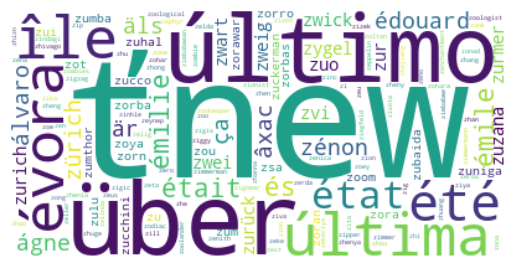

In [48]:
from wordcloud import WordCloud

wordcloud = WordCloud(
    max_words=200, background_color="white").generate_from_frequencies(tfidf.vocabulary_)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Modeling

In [49]:
x_train_resampled.shape,y_train.shape

((367551, 35000), (367551,))

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score


classifiers = [
    MultinomialNB(alpha=0.5),
    BernoulliNB(),
    LogisticRegression(solver="sag", C=0.5, max_iter=500, random_state=42, tol=0.1, n_jobs=4),
    LinearSVC(),
]


for clf in classifiers:
    clf.fit(x_train_resampled, y_train)
    y_pred = clf.predict(X_test_transformed)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {clf.__class__.__name__}: {accuracy}")



Accuracy for MultinomialNB: 0.5162177121771218
Accuracy for BernoulliNB: 0.5274354243542435
Accuracy for LogisticRegression: 0.5156273062730627


C:\Users\vigne\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy for LinearSVC: 0.48383763837638377


### Test accuracy can be improved if we apply all the preprocessing to test data

## Preprocessing the Test data

In [52]:
test["len_desc"] = test["DESCRIPTION"].apply(len)
test["len_clean_desc"] = test["clean_description"].apply(len)

In [53]:
test["clean_description"] = test["clean_description"].apply(lambda x: x[:np.random.randint(250,2000)] if len(x)>2000 else x)

In [54]:
test["len_clean_desc"] = test["clean_description"].apply(len)
(test["len_clean_desc"]>2000).value_counts()

False    54200
Name: len_clean_desc, dtype: int64

In [55]:
test["clean_description"] = test.apply(lambda x: trans(x["clean_description"]) if x['Language']!='en' else x['clean_description'],axis=1)

In [56]:
detect_language(test[test["Language"]!="en"].iloc[0]["clean_description"])

108430


'en'

In [57]:
test["clean_description"] = test["clean_description"].apply(lambda x: lametize(x))

54215
54216
54217
54218
54219
54220
54221
54222
54223
54224
54225
54226
54227
54228
54229
54230
54231
54232
54233
54234
54235
54236
54237
54238
54239
54240
54241
54242
54243
54244
54245
54246
54247
54248
54249
54250
54251
54252
54253
54254
54255
54256
54257
54258
54259
54260
54261
54262
54263
54264
54265
54266
54267
54268
54269
54270
54271
54272
54273
54274
54275
54276
54277
54278
54279
54280
54281
54282
54283
54284
54285
54286
54287
54288
54289
54290
54291
54292
54293
54294
54295
54296
54297
54298
54299
54300
54301
54302
54303
54304
54305
54306
54307
54308
54309
54310
54311
54312
54313
54314
54315
54316
54317
54318
54319
54320
54321
54322
54323
54324
54325
54326
54327
54328
54329
54330
54331
54332
54333
54334
54335
54336
54337
54338
54339
54340
54341
54342
54343
54344
54345
54346
54347
54348
54349
54350
54351
54352
54353
54354
54355
54356
54357
54358
54359
54360
54361
54362
54363
54364
54365
54366
54367
54368
54369
54370
54371
54372
54373
54374
54375
54376
54377
54378
54379
54380
5438

55583
55584
55585
55586
55587
55588
55589
55590
55591
55592
55593
55594
55595
55596
55597
55598
55599
55600
55601
55602
55603
55604
55605
55606
55607
55608
55609
55610
55611
55612
55613
55614
55615
55616
55617
55618
55619
55620
55621
55622
55623
55624
55625
55626
55627
55628
55629
55630
55631
55632
55633
55634
55635
55636
55637
55638
55639
55640
55641
55642
55643
55644
55645
55646
55647
55648
55649
55650
55651
55652
55653
55654
55655
55656
55657
55658
55659
55660
55661
55662
55663
55664
55665
55666
55667
55668
55669
55670
55671
55672
55673
55674
55675
55676
55677
55678
55679
55680
55681
55682
55683
55684
55685
55686
55687
55688
55689
55690
55691
55692
55693
55694
55695
55696
55697
55698
55699
55700
55701
55702
55703
55704
55705
55706
55707
55708
55709
55710
55711
55712
55713
55714
55715
55716
55717
55718
55719
55720
55721
55722
55723
55724
55725
55726
55727
55728
55729
55730
55731
55732
55733
55734
55735
55736
55737
55738
55739
55740
55741
55742
55743
55744
55745
55746
55747
55748
5574

56952
56953
56954
56955
56956
56957
56958
56959
56960
56961
56962
56963
56964
56965
56966
56967
56968
56969
56970
56971
56972
56973
56974
56975
56976
56977
56978
56979
56980
56981
56982
56983
56984
56985
56986
56987
56988
56989
56990
56991
56992
56993
56994
56995
56996
56997
56998
56999
57000
57001
57002
57003
57004
57005
57006
57007
57008
57009
57010
57011
57012
57013
57014
57015
57016
57017
57018
57019
57020
57021
57022
57023
57024
57025
57026
57027
57028
57029
57030
57031
57032
57033
57034
57035
57036
57037
57038
57039
57040
57041
57042
57043
57044
57045
57046
57047
57048
57049
57050
57051
57052
57053
57054
57055
57056
57057
57058
57059
57060
57061
57062
57063
57064
57065
57066
57067
57068
57069
57070
57071
57072
57073
57074
57075
57076
57077
57078
57079
57080
57081
57082
57083
57084
57085
57086
57087
57088
57089
57090
57091
57092
57093
57094
57095
57096
57097
57098
57099
57100
57101
57102
57103
57104
57105
57106
57107
57108
57109
57110
57111
57112
57113
57114
57115
57116
57117
5711

58331
58332
58333
58334
58335
58336
58337
58338
58339
58340
58341
58342
58343
58344
58345
58346
58347
58348
58349
58350
58351
58352
58353
58354
58355
58356
58357
58358
58359
58360
58361
58362
58363
58364
58365
58366
58367
58368
58369
58370
58371
58372
58373
58374
58375
58376
58377
58378
58379
58380
58381
58382
58383
58384
58385
58386
58387
58388
58389
58390
58391
58392
58393
58394
58395
58396
58397
58398
58399
58400
58401
58402
58403
58404
58405
58406
58407
58408
58409
58410
58411
58412
58413
58414
58415
58416
58417
58418
58419
58420
58421
58422
58423
58424
58425
58426
58427
58428
58429
58430
58431
58432
58433
58434
58435
58436
58437
58438
58439
58440
58441
58442
58443
58444
58445
58446
58447
58448
58449
58450
58451
58452
58453
58454
58455
58456
58457
58458
58459
58460
58461
58462
58463
58464
58465
58466
58467
58468
58469
58470
58471
58472
58473
58474
58475
58476
58477
58478
58479
58480
58481
58482
58483
58484
58485
58486
58487
58488
58489
58490
58491
58492
58493
58494
58495
58496
5849

59700
59701
59702
59703
59704
59705
59706
59707
59708
59709
59710
59711
59712
59713
59714
59715
59716
59717
59718
59719
59720
59721
59722
59723
59724
59725
59726
59727
59728
59729
59730
59731
59732
59733
59734
59735
59736
59737
59738
59739
59740
59741
59742
59743
59744
59745
59746
59747
59748
59749
59750
59751
59752
59753
59754
59755
59756
59757
59758
59759
59760
59761
59762
59763
59764
59765
59766
59767
59768
59769
59770
59771
59772
59773
59774
59775
59776
59777
59778
59779
59780
59781
59782
59783
59784
59785
59786
59787
59788
59789
59790
59791
59792
59793
59794
59795
59796
59797
59798
59799
59800
59801
59802
59803
59804
59805
59806
59807
59808
59809
59810
59811
59812
59813
59814
59815
59816
59817
59818
59819
59820
59821
59822
59823
59824
59825
59826
59827
59828
59829
59830
59831
59832
59833
59834
59835
59836
59837
59838
59839
59840
59841
59842
59843
59844
59845
59846
59847
59848
59849
59850
59851
59852
59853
59854
59855
59856
59857
59858
59859
59860
59861
59862
59863
59864
59865
5986

61082
61083
61084
61085
61086
61087
61088
61089
61090
61091
61092
61093
61094
61095
61096
61097
61098
61099
61100
61101
61102
61103
61104
61105
61106
61107
61108
61109
61110
61111
61112
61113
61114
61115
61116
61117
61118
61119
61120
61121
61122
61123
61124
61125
61126
61127
61128
61129
61130
61131
61132
61133
61134
61135
61136
61137
61138
61139
61140
61141
61142
61143
61144
61145
61146
61147
61148
61149
61150
61151
61152
61153
61154
61155
61156
61157
61158
61159
61160
61161
61162
61163
61164
61165
61166
61167
61168
61169
61170
61171
61172
61173
61174
61175
61176
61177
61178
61179
61180
61181
61182
61183
61184
61185
61186
61187
61188
61189
61190
61191
61192
61193
61194
61195
61196
61197
61198
61199
61200
61201
61202
61203
61204
61205
61206
61207
61208
61209
61210
61211
61212
61213
61214
61215
61216
61217
61218
61219
61220
61221
61222
61223
61224
61225
61226
61227
61228
61229
61230
61231
61232
61233
61234
61235
61236
61237
61238
61239
61240
61241
61242
61243
61244
61245
61246
61247
6124

62453
62454
62455
62456
62457
62458
62459
62460
62461
62462
62463
62464
62465
62466
62467
62468
62469
62470
62471
62472
62473
62474
62475
62476
62477
62478
62479
62480
62481
62482
62483
62484
62485
62486
62487
62488
62489
62490
62491
62492
62493
62494
62495
62496
62497
62498
62499
62500
62501
62502
62503
62504
62505
62506
62507
62508
62509
62510
62511
62512
62513
62514
62515
62516
62517
62518
62519
62520
62521
62522
62523
62524
62525
62526
62527
62528
62529
62530
62531
62532
62533
62534
62535
62536
62537
62538
62539
62540
62541
62542
62543
62544
62545
62546
62547
62548
62549
62550
62551
62552
62553
62554
62555
62556
62557
62558
62559
62560
62561
62562
62563
62564
62565
62566
62567
62568
62569
62570
62571
62572
62573
62574
62575
62576
62577
62578
62579
62580
62581
62582
62583
62584
62585
62586
62587
62588
62589
62590
62591
62592
62593
62594
62595
62596
62597
62598
62599
62600
62601
62602
62603
62604
62605
62606
62607
62608
62609
62610
62611
62612
62613
62614
62615
62616
62617
62618
6261

63828
63829
63830
63831
63832
63833
63834
63835
63836
63837
63838
63839
63840
63841
63842
63843
63844
63845
63846
63847
63848
63849
63850
63851
63852
63853
63854
63855
63856
63857
63858
63859
63860
63861
63862
63863
63864
63865
63866
63867
63868
63869
63870
63871
63872
63873
63874
63875
63876
63877
63878
63879
63880
63881
63882
63883
63884
63885
63886
63887
63888
63889
63890
63891
63892
63893
63894
63895
63896
63897
63898
63899
63900
63901
63902
63903
63904
63905
63906
63907
63908
63909
63910
63911
63912
63913
63914
63915
63916
63917
63918
63919
63920
63921
63922
63923
63924
63925
63926
63927
63928
63929
63930
63931
63932
63933
63934
63935
63936
63937
63938
63939
63940
63941
63942
63943
63944
63945
63946
63947
63948
63949
63950
63951
63952
63953
63954
63955
63956
63957
63958
63959
63960
63961
63962
63963
63964
63965
63966
63967
63968
63969
63970
63971
63972
63973
63974
63975
63976
63977
63978
63979
63980
63981
63982
63983
63984
63985
63986
63987
63988
63989
63990
63991
63992
63993
6399

65203
65204
65205
65206
65207
65208
65209
65210
65211
65212
65213
65214
65215
65216
65217
65218
65219
65220
65221
65222
65223
65224
65225
65226
65227
65228
65229
65230
65231
65232
65233
65234
65235
65236
65237
65238
65239
65240
65241
65242
65243
65244
65245
65246
65247
65248
65249
65250
65251
65252
65253
65254
65255
65256
65257
65258
65259
65260
65261
65262
65263
65264
65265
65266
65267
65268
65269
65270
65271
65272
65273
65274
65275
65276
65277
65278
65279
65280
65281
65282
65283
65284
65285
65286
65287
65288
65289
65290
65291
65292
65293
65294
65295
65296
65297
65298
65299
65300
65301
65302
65303
65304
65305
65306
65307
65308
65309
65310
65311
65312
65313
65314
65315
65316
65317
65318
65319
65320
65321
65322
65323
65324
65325
65326
65327
65328
65329
65330
65331
65332
65333
65334
65335
65336
65337
65338
65339
65340
65341
65342
65343
65344
65345
65346
65347
65348
65349
65350
65351
65352
65353
65354
65355
65356
65357
65358
65359
65360
65361
65362
65363
65364
65365
65366
65367
65368
6536

66577
66578
66579
66580
66581
66582
66583
66584
66585
66586
66587
66588
66589
66590
66591
66592
66593
66594
66595
66596
66597
66598
66599
66600
66601
66602
66603
66604
66605
66606
66607
66608
66609
66610
66611
66612
66613
66614
66615
66616
66617
66618
66619
66620
66621
66622
66623
66624
66625
66626
66627
66628
66629
66630
66631
66632
66633
66634
66635
66636
66637
66638
66639
66640
66641
66642
66643
66644
66645
66646
66647
66648
66649
66650
66651
66652
66653
66654
66655
66656
66657
66658
66659
66660
66661
66662
66663
66664
66665
66666
66667
66668
66669
66670
66671
66672
66673
66674
66675
66676
66677
66678
66679
66680
66681
66682
66683
66684
66685
66686
66687
66688
66689
66690
66691
66692
66693
66694
66695
66696
66697
66698
66699
66700
66701
66702
66703
66704
66705
66706
66707
66708
66709
66710
66711
66712
66713
66714
66715
66716
66717
66718
66719
66720
66721
66722
66723
66724
66725
66726
66727
66728
66729
66730
66731
66732
66733
66734
66735
66736
66737
66738
66739
66740
66741
66742
6674

67947
67948
67949
67950
67951
67952
67953
67954
67955
67956
67957
67958
67959
67960
67961
67962
67963
67964
67965
67966
67967
67968
67969
67970
67971
67972
67973
67974
67975
67976
67977
67978
67979
67980
67981
67982
67983
67984
67985
67986
67987
67988
67989
67990
67991
67992
67993
67994
67995
67996
67997
67998
67999
68000
68001
68002
68003
68004
68005
68006
68007
68008
68009
68010
68011
68012
68013
68014
68015
68016
68017
68018
68019
68020
68021
68022
68023
68024
68025
68026
68027
68028
68029
68030
68031
68032
68033
68034
68035
68036
68037
68038
68039
68040
68041
68042
68043
68044
68045
68046
68047
68048
68049
68050
68051
68052
68053
68054
68055
68056
68057
68058
68059
68060
68061
68062
68063
68064
68065
68066
68067
68068
68069
68070
68071
68072
68073
68074
68075
68076
68077
68078
68079
68080
68081
68082
68083
68084
68085
68086
68087
68088
68089
68090
68091
68092
68093
68094
68095
68096
68097
68098
68099
68100
68101
68102
68103
68104
68105
68106
68107
68108
68109
68110
68111
68112
6811

69320
69321
69322
69323
69324
69325
69326
69327
69328
69329
69330
69331
69332
69333
69334
69335
69336
69337
69338
69339
69340
69341
69342
69343
69344
69345
69346
69347
69348
69349
69350
69351
69352
69353
69354
69355
69356
69357
69358
69359
69360
69361
69362
69363
69364
69365
69366
69367
69368
69369
69370
69371
69372
69373
69374
69375
69376
69377
69378
69379
69380
69381
69382
69383
69384
69385
69386
69387
69388
69389
69390
69391
69392
69393
69394
69395
69396
69397
69398
69399
69400
69401
69402
69403
69404
69405
69406
69407
69408
69409
69410
69411
69412
69413
69414
69415
69416
69417
69418
69419
69420
69421
69422
69423
69424
69425
69426
69427
69428
69429
69430
69431
69432
69433
69434
69435
69436
69437
69438
69439
69440
69441
69442
69443
69444
69445
69446
69447
69448
69449
69450
69451
69452
69453
69454
69455
69456
69457
69458
69459
69460
69461
69462
69463
69464
69465
69466
69467
69468
69469
69470
69471
69472
69473
69474
69475
69476
69477
69478
69479
69480
69481
69482
69483
69484
69485
6948

70702
70703
70704
70705
70706
70707
70708
70709
70710
70711
70712
70713
70714
70715
70716
70717
70718
70719
70720
70721
70722
70723
70724
70725
70726
70727
70728
70729
70730
70731
70732
70733
70734
70735
70736
70737
70738
70739
70740
70741
70742
70743
70744
70745
70746
70747
70748
70749
70750
70751
70752
70753
70754
70755
70756
70757
70758
70759
70760
70761
70762
70763
70764
70765
70766
70767
70768
70769
70770
70771
70772
70773
70774
70775
70776
70777
70778
70779
70780
70781
70782
70783
70784
70785
70786
70787
70788
70789
70790
70791
70792
70793
70794
70795
70796
70797
70798
70799
70800
70801
70802
70803
70804
70805
70806
70807
70808
70809
70810
70811
70812
70813
70814
70815
70816
70817
70818
70819
70820
70821
70822
70823
70824
70825
70826
70827
70828
70829
70830
70831
70832
70833
70834
70835
70836
70837
70838
70839
70840
70841
70842
70843
70844
70845
70846
70847
70848
70849
70850
70851
70852
70853
70854
70855
70856
70857
70858
70859
70860
70861
70862
70863
70864
70865
70866
70867
7086

72078
72079
72080
72081
72082
72083
72084
72085
72086
72087
72088
72089
72090
72091
72092
72093
72094
72095
72096
72097
72098
72099
72100
72101
72102
72103
72104
72105
72106
72107
72108
72109
72110
72111
72112
72113
72114
72115
72116
72117
72118
72119
72120
72121
72122
72123
72124
72125
72126
72127
72128
72129
72130
72131
72132
72133
72134
72135
72136
72137
72138
72139
72140
72141
72142
72143
72144
72145
72146
72147
72148
72149
72150
72151
72152
72153
72154
72155
72156
72157
72158
72159
72160
72161
72162
72163
72164
72165
72166
72167
72168
72169
72170
72171
72172
72173
72174
72175
72176
72177
72178
72179
72180
72181
72182
72183
72184
72185
72186
72187
72188
72189
72190
72191
72192
72193
72194
72195
72196
72197
72198
72199
72200
72201
72202
72203
72204
72205
72206
72207
72208
72209
72210
72211
72212
72213
72214
72215
72216
72217
72218
72219
72220
72221
72222
72223
72224
72225
72226
72227
72228
72229
72230
72231
72232
72233
72234
72235
72236
72237
72238
72239
72240
72241
72242
72243
7224

73452
73453
73454
73455
73456
73457
73458
73459
73460
73461
73462
73463
73464
73465
73466
73467
73468
73469
73470
73471
73472
73473
73474
73475
73476
73477
73478
73479
73480
73481
73482
73483
73484
73485
73486
73487
73488
73489
73490
73491
73492
73493
73494
73495
73496
73497
73498
73499
73500
73501
73502
73503
73504
73505
73506
73507
73508
73509
73510
73511
73512
73513
73514
73515
73516
73517
73518
73519
73520
73521
73522
73523
73524
73525
73526
73527
73528
73529
73530
73531
73532
73533
73534
73535
73536
73537
73538
73539
73540
73541
73542
73543
73544
73545
73546
73547
73548
73549
73550
73551
73552
73553
73554
73555
73556
73557
73558
73559
73560
73561
73562
73563
73564
73565
73566
73567
73568
73569
73570
73571
73572
73573
73574
73575
73576
73577
73578
73579
73580
73581
73582
73583
73584
73585
73586
73587
73588
73589
73590
73591
73592
73593
73594
73595
73596
73597
73598
73599
73600
73601
73602
73603
73604
73605
73606
73607
73608
73609
73610
73611
73612
73613
73614
73615
73616
73617
7361

74819
74820
74821
74822
74823
74824
74825
74826
74827
74828
74829
74830
74831
74832
74833
74834
74835
74836
74837
74838
74839
74840
74841
74842
74843
74844
74845
74846
74847
74848
74849
74850
74851
74852
74853
74854
74855
74856
74857
74858
74859
74860
74861
74862
74863
74864
74865
74866
74867
74868
74869
74870
74871
74872
74873
74874
74875
74876
74877
74878
74879
74880
74881
74882
74883
74884
74885
74886
74887
74888
74889
74890
74891
74892
74893
74894
74895
74896
74897
74898
74899
74900
74901
74902
74903
74904
74905
74906
74907
74908
74909
74910
74911
74912
74913
74914
74915
74916
74917
74918
74919
74920
74921
74922
74923
74924
74925
74926
74927
74928
74929
74930
74931
74932
74933
74934
74935
74936
74937
74938
74939
74940
74941
74942
74943
74944
74945
74946
74947
74948
74949
74950
74951
74952
74953
74954
74955
74956
74957
74958
74959
74960
74961
74962
74963
74964
74965
74966
74967
74968
74969
74970
74971
74972
74973
74974
74975
74976
74977
74978
74979
74980
74981
74982
74983
74984
7498

76190
76191
76192
76193
76194
76195
76196
76197
76198
76199
76200
76201
76202
76203
76204
76205
76206
76207
76208
76209
76210
76211
76212
76213
76214
76215
76216
76217
76218
76219
76220
76221
76222
76223
76224
76225
76226
76227
76228
76229
76230
76231
76232
76233
76234
76235
76236
76237
76238
76239
76240
76241
76242
76243
76244
76245
76246
76247
76248
76249
76250
76251
76252
76253
76254
76255
76256
76257
76258
76259
76260
76261
76262
76263
76264
76265
76266
76267
76268
76269
76270
76271
76272
76273
76274
76275
76276
76277
76278
76279
76280
76281
76282
76283
76284
76285
76286
76287
76288
76289
76290
76291
76292
76293
76294
76295
76296
76297
76298
76299
76300
76301
76302
76303
76304
76305
76306
76307
76308
76309
76310
76311
76312
76313
76314
76315
76316
76317
76318
76319
76320
76321
76322
76323
76324
76325
76326
76327
76328
76329
76330
76331
76332
76333
76334
76335
76336
76337
76338
76339
76340
76341
76342
76343
76344
76345
76346
76347
76348
76349
76350
76351
76352
76353
76354
76355
7635

77565
77566
77567
77568
77569
77570
77571
77572
77573
77574
77575
77576
77577
77578
77579
77580
77581
77582
77583
77584
77585
77586
77587
77588
77589
77590
77591
77592
77593
77594
77595
77596
77597
77598
77599
77600
77601
77602
77603
77604
77605
77606
77607
77608
77609
77610
77611
77612
77613
77614
77615
77616
77617
77618
77619
77620
77621
77622
77623
77624
77625
77626
77627
77628
77629
77630
77631
77632
77633
77634
77635
77636
77637
77638
77639
77640
77641
77642
77643
77644
77645
77646
77647
77648
77649
77650
77651
77652
77653
77654
77655
77656
77657
77658
77659
77660
77661
77662
77663
77664
77665
77666
77667
77668
77669
77670
77671
77672
77673
77674
77675
77676
77677
77678
77679
77680
77681
77682
77683
77684
77685
77686
77687
77688
77689
77690
77691
77692
77693
77694
77695
77696
77697
77698
77699
77700
77701
77702
77703
77704
77705
77706
77707
77708
77709
77710
77711
77712
77713
77714
77715
77716
77717
77718
77719
77720
77721
77722
77723
77724
77725
77726
77727
77728
77729
77730
7773

78944
78945
78946
78947
78948
78949
78950
78951
78952
78953
78954
78955
78956
78957
78958
78959
78960
78961
78962
78963
78964
78965
78966
78967
78968
78969
78970
78971
78972
78973
78974
78975
78976
78977
78978
78979
78980
78981
78982
78983
78984
78985
78986
78987
78988
78989
78990
78991
78992
78993
78994
78995
78996
78997
78998
78999
79000
79001
79002
79003
79004
79005
79006
79007
79008
79009
79010
79011
79012
79013
79014
79015
79016
79017
79018
79019
79020
79021
79022
79023
79024
79025
79026
79027
79028
79029
79030
79031
79032
79033
79034
79035
79036
79037
79038
79039
79040
79041
79042
79043
79044
79045
79046
79047
79048
79049
79050
79051
79052
79053
79054
79055
79056
79057
79058
79059
79060
79061
79062
79063
79064
79065
79066
79067
79068
79069
79070
79071
79072
79073
79074
79075
79076
79077
79078
79079
79080
79081
79082
79083
79084
79085
79086
79087
79088
79089
79090
79091
79092
79093
79094
79095
79096
79097
79098
79099
79100
79101
79102
79103
79104
79105
79106
79107
79108
79109
7911

80322
80323
80324
80325
80326
80327
80328
80329
80330
80331
80332
80333
80334
80335
80336
80337
80338
80339
80340
80341
80342
80343
80344
80345
80346
80347
80348
80349
80350
80351
80352
80353
80354
80355
80356
80357
80358
80359
80360
80361
80362
80363
80364
80365
80366
80367
80368
80369
80370
80371
80372
80373
80374
80375
80376
80377
80378
80379
80380
80381
80382
80383
80384
80385
80386
80387
80388
80389
80390
80391
80392
80393
80394
80395
80396
80397
80398
80399
80400
80401
80402
80403
80404
80405
80406
80407
80408
80409
80410
80411
80412
80413
80414
80415
80416
80417
80418
80419
80420
80421
80422
80423
80424
80425
80426
80427
80428
80429
80430
80431
80432
80433
80434
80435
80436
80437
80438
80439
80440
80441
80442
80443
80444
80445
80446
80447
80448
80449
80450
80451
80452
80453
80454
80455
80456
80457
80458
80459
80460
80461
80462
80463
80464
80465
80466
80467
80468
80469
80470
80471
80472
80473
80474
80475
80476
80477
80478
80479
80480
80481
80482
80483
80484
80485
80486
80487
8048

81695
81696
81697
81698
81699
81700
81701
81702
81703
81704
81705
81706
81707
81708
81709
81710
81711
81712
81713
81714
81715
81716
81717
81718
81719
81720
81721
81722
81723
81724
81725
81726
81727
81728
81729
81730
81731
81732
81733
81734
81735
81736
81737
81738
81739
81740
81741
81742
81743
81744
81745
81746
81747
81748
81749
81750
81751
81752
81753
81754
81755
81756
81757
81758
81759
81760
81761
81762
81763
81764
81765
81766
81767
81768
81769
81770
81771
81772
81773
81774
81775
81776
81777
81778
81779
81780
81781
81782
81783
81784
81785
81786
81787
81788
81789
81790
81791
81792
81793
81794
81795
81796
81797
81798
81799
81800
81801
81802
81803
81804
81805
81806
81807
81808
81809
81810
81811
81812
81813
81814
81815
81816
81817
81818
81819
81820
81821
81822
81823
81824
81825
81826
81827
81828
81829
81830
81831
81832
81833
81834
81835
81836
81837
81838
81839
81840
81841
81842
81843
81844
81845
81846
81847
81848
81849
81850
81851
81852
81853
81854
81855
81856
81857
81858
81859
81860
8186

83071
83072
83073
83074
83075
83076
83077
83078
83079
83080
83081
83082
83083
83084
83085
83086
83087
83088
83089
83090
83091
83092
83093
83094
83095
83096
83097
83098
83099
83100
83101
83102
83103
83104
83105
83106
83107
83108
83109
83110
83111
83112
83113
83114
83115
83116
83117
83118
83119
83120
83121
83122
83123
83124
83125
83126
83127
83128
83129
83130
83131
83132
83133
83134
83135
83136
83137
83138
83139
83140
83141
83142
83143
83144
83145
83146
83147
83148
83149
83150
83151
83152
83153
83154
83155
83156
83157
83158
83159
83160
83161
83162
83163
83164
83165
83166
83167
83168
83169
83170
83171
83172
83173
83174
83175
83176
83177
83178
83179
83180
83181
83182
83183
83184
83185
83186
83187
83188
83189
83190
83191
83192
83193
83194
83195
83196
83197
83198
83199
83200
83201
83202
83203
83204
83205
83206
83207
83208
83209
83210
83211
83212
83213
83214
83215
83216
83217
83218
83219
83220
83221
83222
83223
83224
83225
83226
83227
83228
83229
83230
83231
83232
83233
83234
83235
83236
8323

84446
84447
84448
84449
84450
84451
84452
84453
84454
84455
84456
84457
84458
84459
84460
84461
84462
84463
84464
84465
84466
84467
84468
84469
84470
84471
84472
84473
84474
84475
84476
84477
84478
84479
84480
84481
84482
84483
84484
84485
84486
84487
84488
84489
84490
84491
84492
84493
84494
84495
84496
84497
84498
84499
84500
84501
84502
84503
84504
84505
84506
84507
84508
84509
84510
84511
84512
84513
84514
84515
84516
84517
84518
84519
84520
84521
84522
84523
84524
84525
84526
84527
84528
84529
84530
84531
84532
84533
84534
84535
84536
84537
84538
84539
84540
84541
84542
84543
84544
84545
84546
84547
84548
84549
84550
84551
84552
84553
84554
84555
84556
84557
84558
84559
84560
84561
84562
84563
84564
84565
84566
84567
84568
84569
84570
84571
84572
84573
84574
84575
84576
84577
84578
84579
84580
84581
84582
84583
84584
84585
84586
84587
84588
84589
84590
84591
84592
84593
84594
84595
84596
84597
84598
84599
84600
84601
84602
84603
84604
84605
84606
84607
84608
84609
84610
84611
8461

85818
85819
85820
85821
85822
85823
85824
85825
85826
85827
85828
85829
85830
85831
85832
85833
85834
85835
85836
85837
85838
85839
85840
85841
85842
85843
85844
85845
85846
85847
85848
85849
85850
85851
85852
85853
85854
85855
85856
85857
85858
85859
85860
85861
85862
85863
85864
85865
85866
85867
85868
85869
85870
85871
85872
85873
85874
85875
85876
85877
85878
85879
85880
85881
85882
85883
85884
85885
85886
85887
85888
85889
85890
85891
85892
85893
85894
85895
85896
85897
85898
85899
85900
85901
85902
85903
85904
85905
85906
85907
85908
85909
85910
85911
85912
85913
85914
85915
85916
85917
85918
85919
85920
85921
85922
85923
85924
85925
85926
85927
85928
85929
85930
85931
85932
85933
85934
85935
85936
85937
85938
85939
85940
85941
85942
85943
85944
85945
85946
85947
85948
85949
85950
85951
85952
85953
85954
85955
85956
85957
85958
85959
85960
85961
85962
85963
85964
85965
85966
85967
85968
85969
85970
85971
85972
85973
85974
85975
85976
85977
85978
85979
85980
85981
85982
85983
8598

87195
87196
87197
87198
87199
87200
87201
87202
87203
87204
87205
87206
87207
87208
87209
87210
87211
87212
87213
87214
87215
87216
87217
87218
87219
87220
87221
87222
87223
87224
87225
87226
87227
87228
87229
87230
87231
87232
87233
87234
87235
87236
87237
87238
87239
87240
87241
87242
87243
87244
87245
87246
87247
87248
87249
87250
87251
87252
87253
87254
87255
87256
87257
87258
87259
87260
87261
87262
87263
87264
87265
87266
87267
87268
87269
87270
87271
87272
87273
87274
87275
87276
87277
87278
87279
87280
87281
87282
87283
87284
87285
87286
87287
87288
87289
87290
87291
87292
87293
87294
87295
87296
87297
87298
87299
87300
87301
87302
87303
87304
87305
87306
87307
87308
87309
87310
87311
87312
87313
87314
87315
87316
87317
87318
87319
87320
87321
87322
87323
87324
87325
87326
87327
87328
87329
87330
87331
87332
87333
87334
87335
87336
87337
87338
87339
87340
87341
87342
87343
87344
87345
87346
87347
87348
87349
87350
87351
87352
87353
87354
87355
87356
87357
87358
87359
87360
8736

88571
88572
88573
88574
88575
88576
88577
88578
88579
88580
88581
88582
88583
88584
88585
88586
88587
88588
88589
88590
88591
88592
88593
88594
88595
88596
88597
88598
88599
88600
88601
88602
88603
88604
88605
88606
88607
88608
88609
88610
88611
88612
88613
88614
88615
88616
88617
88618
88619
88620
88621
88622
88623
88624
88625
88626
88627
88628
88629
88630
88631
88632
88633
88634
88635
88636
88637
88638
88639
88640
88641
88642
88643
88644
88645
88646
88647
88648
88649
88650
88651
88652
88653
88654
88655
88656
88657
88658
88659
88660
88661
88662
88663
88664
88665
88666
88667
88668
88669
88670
88671
88672
88673
88674
88675
88676
88677
88678
88679
88680
88681
88682
88683
88684
88685
88686
88687
88688
88689
88690
88691
88692
88693
88694
88695
88696
88697
88698
88699
88700
88701
88702
88703
88704
88705
88706
88707
88708
88709
88710
88711
88712
88713
88714
88715
88716
88717
88718
88719
88720
88721
88722
88723
88724
88725
88726
88727
88728
88729
88730
88731
88732
88733
88734
88735
88736
8873

89949
89950
89951
89952
89953
89954
89955
89956
89957
89958
89959
89960
89961
89962
89963
89964
89965
89966
89967
89968
89969
89970
89971
89972
89973
89974
89975
89976
89977
89978
89979
89980
89981
89982
89983
89984
89985
89986
89987
89988
89989
89990
89991
89992
89993
89994
89995
89996
89997
89998
89999
90000
90001
90002
90003
90004
90005
90006
90007
90008
90009
90010
90011
90012
90013
90014
90015
90016
90017
90018
90019
90020
90021
90022
90023
90024
90025
90026
90027
90028
90029
90030
90031
90032
90033
90034
90035
90036
90037
90038
90039
90040
90041
90042
90043
90044
90045
90046
90047
90048
90049
90050
90051
90052
90053
90054
90055
90056
90057
90058
90059
90060
90061
90062
90063
90064
90065
90066
90067
90068
90069
90070
90071
90072
90073
90074
90075
90076
90077
90078
90079
90080
90081
90082
90083
90084
90085
90086
90087
90088
90089
90090
90091
90092
90093
90094
90095
90096
90097
90098
90099
90100
90101
90102
90103
90104
90105
90106
90107
90108
90109
90110
90111
90112
90113
90114
9011

91323
91324
91325
91326
91327
91328
91329
91330
91331
91332
91333
91334
91335
91336
91337
91338
91339
91340
91341
91342
91343
91344
91345
91346
91347
91348
91349
91350
91351
91352
91353
91354
91355
91356
91357
91358
91359
91360
91361
91362
91363
91364
91365
91366
91367
91368
91369
91370
91371
91372
91373
91374
91375
91376
91377
91378
91379
91380
91381
91382
91383
91384
91385
91386
91387
91388
91389
91390
91391
91392
91393
91394
91395
91396
91397
91398
91399
91400
91401
91402
91403
91404
91405
91406
91407
91408
91409
91410
91411
91412
91413
91414
91415
91416
91417
91418
91419
91420
91421
91422
91423
91424
91425
91426
91427
91428
91429
91430
91431
91432
91433
91434
91435
91436
91437
91438
91439
91440
91441
91442
91443
91444
91445
91446
91447
91448
91449
91450
91451
91452
91453
91454
91455
91456
91457
91458
91459
91460
91461
91462
91463
91464
91465
91466
91467
91468
91469
91470
91471
91472
91473
91474
91475
91476
91477
91478
91479
91480
91481
91482
91483
91484
91485
91486
91487
91488
9148

92701
92702
92703
92704
92705
92706
92707
92708
92709
92710
92711
92712
92713
92714
92715
92716
92717
92718
92719
92720
92721
92722
92723
92724
92725
92726
92727
92728
92729
92730
92731
92732
92733
92734
92735
92736
92737
92738
92739
92740
92741
92742
92743
92744
92745
92746
92747
92748
92749
92750
92751
92752
92753
92754
92755
92756
92757
92758
92759
92760
92761
92762
92763
92764
92765
92766
92767
92768
92769
92770
92771
92772
92773
92774
92775
92776
92777
92778
92779
92780
92781
92782
92783
92784
92785
92786
92787
92788
92789
92790
92791
92792
92793
92794
92795
92796
92797
92798
92799
92800
92801
92802
92803
92804
92805
92806
92807
92808
92809
92810
92811
92812
92813
92814
92815
92816
92817
92818
92819
92820
92821
92822
92823
92824
92825
92826
92827
92828
92829
92830
92831
92832
92833
92834
92835
92836
92837
92838
92839
92840
92841
92842
92843
92844
92845
92846
92847
92848
92849
92850
92851
92852
92853
92854
92855
92856
92857
92858
92859
92860
92861
92862
92863
92864
92865
92866
9286

94071
94072
94073
94074
94075
94076
94077
94078
94079
94080
94081
94082
94083
94084
94085
94086
94087
94088
94089
94090
94091
94092
94093
94094
94095
94096
94097
94098
94099
94100
94101
94102
94103
94104
94105
94106
94107
94108
94109
94110
94111
94112
94113
94114
94115
94116
94117
94118
94119
94120
94121
94122
94123
94124
94125
94126
94127
94128
94129
94130
94131
94132
94133
94134
94135
94136
94137
94138
94139
94140
94141
94142
94143
94144
94145
94146
94147
94148
94149
94150
94151
94152
94153
94154
94155
94156
94157
94158
94159
94160
94161
94162
94163
94164
94165
94166
94167
94168
94169
94170
94171
94172
94173
94174
94175
94176
94177
94178
94179
94180
94181
94182
94183
94184
94185
94186
94187
94188
94189
94190
94191
94192
94193
94194
94195
94196
94197
94198
94199
94200
94201
94202
94203
94204
94205
94206
94207
94208
94209
94210
94211
94212
94213
94214
94215
94216
94217
94218
94219
94220
94221
94222
94223
94224
94225
94226
94227
94228
94229
94230
94231
94232
94233
94234
94235
94236
9423

95451
95452
95453
95454
95455
95456
95457
95458
95459
95460
95461
95462
95463
95464
95465
95466
95467
95468
95469
95470
95471
95472
95473
95474
95475
95476
95477
95478
95479
95480
95481
95482
95483
95484
95485
95486
95487
95488
95489
95490
95491
95492
95493
95494
95495
95496
95497
95498
95499
95500
95501
95502
95503
95504
95505
95506
95507
95508
95509
95510
95511
95512
95513
95514
95515
95516
95517
95518
95519
95520
95521
95522
95523
95524
95525
95526
95527
95528
95529
95530
95531
95532
95533
95534
95535
95536
95537
95538
95539
95540
95541
95542
95543
95544
95545
95546
95547
95548
95549
95550
95551
95552
95553
95554
95555
95556
95557
95558
95559
95560
95561
95562
95563
95564
95565
95566
95567
95568
95569
95570
95571
95572
95573
95574
95575
95576
95577
95578
95579
95580
95581
95582
95583
95584
95585
95586
95587
95588
95589
95590
95591
95592
95593
95594
95595
95596
95597
95598
95599
95600
95601
95602
95603
95604
95605
95606
95607
95608
95609
95610
95611
95612
95613
95614
95615
95616
9561

96819
96820
96821
96822
96823
96824
96825
96826
96827
96828
96829
96830
96831
96832
96833
96834
96835
96836
96837
96838
96839
96840
96841
96842
96843
96844
96845
96846
96847
96848
96849
96850
96851
96852
96853
96854
96855
96856
96857
96858
96859
96860
96861
96862
96863
96864
96865
96866
96867
96868
96869
96870
96871
96872
96873
96874
96875
96876
96877
96878
96879
96880
96881
96882
96883
96884
96885
96886
96887
96888
96889
96890
96891
96892
96893
96894
96895
96896
96897
96898
96899
96900
96901
96902
96903
96904
96905
96906
96907
96908
96909
96910
96911
96912
96913
96914
96915
96916
96917
96918
96919
96920
96921
96922
96923
96924
96925
96926
96927
96928
96929
96930
96931
96932
96933
96934
96935
96936
96937
96938
96939
96940
96941
96942
96943
96944
96945
96946
96947
96948
96949
96950
96951
96952
96953
96954
96955
96956
96957
96958
96959
96960
96961
96962
96963
96964
96965
96966
96967
96968
96969
96970
96971
96972
96973
96974
96975
96976
96977
96978
96979
96980
96981
96982
96983
96984
9698

98200
98201
98202
98203
98204
98205
98206
98207
98208
98209
98210
98211
98212
98213
98214
98215
98216
98217
98218
98219
98220
98221
98222
98223
98224
98225
98226
98227
98228
98229
98230
98231
98232
98233
98234
98235
98236
98237
98238
98239
98240
98241
98242
98243
98244
98245
98246
98247
98248
98249
98250
98251
98252
98253
98254
98255
98256
98257
98258
98259
98260
98261
98262
98263
98264
98265
98266
98267
98268
98269
98270
98271
98272
98273
98274
98275
98276
98277
98278
98279
98280
98281
98282
98283
98284
98285
98286
98287
98288
98289
98290
98291
98292
98293
98294
98295
98296
98297
98298
98299
98300
98301
98302
98303
98304
98305
98306
98307
98308
98309
98310
98311
98312
98313
98314
98315
98316
98317
98318
98319
98320
98321
98322
98323
98324
98325
98326
98327
98328
98329
98330
98331
98332
98333
98334
98335
98336
98337
98338
98339
98340
98341
98342
98343
98344
98345
98346
98347
98348
98349
98350
98351
98352
98353
98354
98355
98356
98357
98358
98359
98360
98361
98362
98363
98364
98365
9836

99585
99586
99587
99588
99589
99590
99591
99592
99593
99594
99595
99596
99597
99598
99599
99600
99601
99602
99603
99604
99605
99606
99607
99608
99609
99610
99611
99612
99613
99614
99615
99616
99617
99618
99619
99620
99621
99622
99623
99624
99625
99626
99627
99628
99629
99630
99631
99632
99633
99634
99635
99636
99637
99638
99639
99640
99641
99642
99643
99644
99645
99646
99647
99648
99649
99650
99651
99652
99653
99654
99655
99656
99657
99658
99659
99660
99661
99662
99663
99664
99665
99666
99667
99668
99669
99670
99671
99672
99673
99674
99675
99676
99677
99678
99679
99680
99681
99682
99683
99684
99685
99686
99687
99688
99689
99690
99691
99692
99693
99694
99695
99696
99697
99698
99699
99700
99701
99702
99703
99704
99705
99706
99707
99708
99709
99710
99711
99712
99713
99714
99715
99716
99717
99718
99719
99720
99721
99722
99723
99724
99725
99726
99727
99728
99729
99730
99731
99732
99733
99734
99735
99736
99737
99738
99739
99740
99741
99742
99743
99744
99745
99746
99747
99748
99749
99750
9975

100823
100824
100825
100826
100827
100828
100829
100830
100831
100832
100833
100834
100835
100836
100837
100838
100839
100840
100841
100842
100843
100844
100845
100846
100847
100848
100849
100850
100851
100852
100853
100854
100855
100856
100857
100858
100859
100860
100861
100862
100863
100864
100865
100866
100867
100868
100869
100870
100871
100872
100873
100874
100875
100876
100877
100878
100879
100880
100881
100882
100883
100884
100885
100886
100887
100888
100889
100890
100891
100892
100893
100894
100895
100896
100897
100898
100899
100900
100901
100902
100903
100904
100905
100906
100907
100908
100909
100910
100911
100912
100913
100914
100915
100916
100917
100918
100919
100920
100921
100922
100923
100924
100925
100926
100927
100928
100929
100930
100931
100932
100933
100934
100935
100936
100937
100938
100939
100940
100941
100942
100943
100944
100945
100946
100947
100948
100949
100950
100951
100952
100953
100954
100955
100956
100957
100958
100959
100960
100961
100962
100963
100964
100965

102001
102002
102003
102004
102005
102006
102007
102008
102009
102010
102011
102012
102013
102014
102015
102016
102017
102018
102019
102020
102021
102022
102023
102024
102025
102026
102027
102028
102029
102030
102031
102032
102033
102034
102035
102036
102037
102038
102039
102040
102041
102042
102043
102044
102045
102046
102047
102048
102049
102050
102051
102052
102053
102054
102055
102056
102057
102058
102059
102060
102061
102062
102063
102064
102065
102066
102067
102068
102069
102070
102071
102072
102073
102074
102075
102076
102077
102078
102079
102080
102081
102082
102083
102084
102085
102086
102087
102088
102089
102090
102091
102092
102093
102094
102095
102096
102097
102098
102099
102100
102101
102102
102103
102104
102105
102106
102107
102108
102109
102110
102111
102112
102113
102114
102115
102116
102117
102118
102119
102120
102121
102122
102123
102124
102125
102126
102127
102128
102129
102130
102131
102132
102133
102134
102135
102136
102137
102138
102139
102140
102141
102142
102143

103180
103181
103182
103183
103184
103185
103186
103187
103188
103189
103190
103191
103192
103193
103194
103195
103196
103197
103198
103199
103200
103201
103202
103203
103204
103205
103206
103207
103208
103209
103210
103211
103212
103213
103214
103215
103216
103217
103218
103219
103220
103221
103222
103223
103224
103225
103226
103227
103228
103229
103230
103231
103232
103233
103234
103235
103236
103237
103238
103239
103240
103241
103242
103243
103244
103245
103246
103247
103248
103249
103250
103251
103252
103253
103254
103255
103256
103257
103258
103259
103260
103261
103262
103263
103264
103265
103266
103267
103268
103269
103270
103271
103272
103273
103274
103275
103276
103277
103278
103279
103280
103281
103282
103283
103284
103285
103286
103287
103288
103289
103290
103291
103292
103293
103294
103295
103296
103297
103298
103299
103300
103301
103302
103303
103304
103305
103306
103307
103308
103309
103310
103311
103312
103313
103314
103315
103316
103317
103318
103319
103320
103321
103322

104373
104374
104375
104376
104377
104378
104379
104380
104381
104382
104383
104384
104385
104386
104387
104388
104389
104390
104391
104392
104393
104394
104395
104396
104397
104398
104399
104400
104401
104402
104403
104404
104405
104406
104407
104408
104409
104410
104411
104412
104413
104414
104415
104416
104417
104418
104419
104420
104421
104422
104423
104424
104425
104426
104427
104428
104429
104430
104431
104432
104433
104434
104435
104436
104437
104438
104439
104440
104441
104442
104443
104444
104445
104446
104447
104448
104449
104450
104451
104452
104453
104454
104455
104456
104457
104458
104459
104460
104461
104462
104463
104464
104465
104466
104467
104468
104469
104470
104471
104472
104473
104474
104475
104476
104477
104478
104479
104480
104481
104482
104483
104484
104485
104486
104487
104488
104489
104490
104491
104492
104493
104494
104495
104496
104497
104498
104499
104500
104501
104502
104503
104504
104505
104506
104507
104508
104509
104510
104511
104512
104513
104514
104515

105557
105558
105559
105560
105561
105562
105563
105564
105565
105566
105567
105568
105569
105570
105571
105572
105573
105574
105575
105576
105577
105578
105579
105580
105581
105582
105583
105584
105585
105586
105587
105588
105589
105590
105591
105592
105593
105594
105595
105596
105597
105598
105599
105600
105601
105602
105603
105604
105605
105606
105607
105608
105609
105610
105611
105612
105613
105614
105615
105616
105617
105618
105619
105620
105621
105622
105623
105624
105625
105626
105627
105628
105629
105630
105631
105632
105633
105634
105635
105636
105637
105638
105639
105640
105641
105642
105643
105644
105645
105646
105647
105648
105649
105650
105651
105652
105653
105654
105655
105656
105657
105658
105659
105660
105661
105662
105663
105664
105665
105666
105667
105668
105669
105670
105671
105672
105673
105674
105675
105676
105677
105678
105679
105680
105681
105682
105683
105684
105685
105686
105687
105688
105689
105690
105691
105692
105693
105694
105695
105696
105697
105698
105699

106730
106731
106732
106733
106734
106735
106736
106737
106738
106739
106740
106741
106742
106743
106744
106745
106746
106747
106748
106749
106750
106751
106752
106753
106754
106755
106756
106757
106758
106759
106760
106761
106762
106763
106764
106765
106766
106767
106768
106769
106770
106771
106772
106773
106774
106775
106776
106777
106778
106779
106780
106781
106782
106783
106784
106785
106786
106787
106788
106789
106790
106791
106792
106793
106794
106795
106796
106797
106798
106799
106800
106801
106802
106803
106804
106805
106806
106807
106808
106809
106810
106811
106812
106813
106814
106815
106816
106817
106818
106819
106820
106821
106822
106823
106824
106825
106826
106827
106828
106829
106830
106831
106832
106833
106834
106835
106836
106837
106838
106839
106840
106841
106842
106843
106844
106845
106846
106847
106848
106849
106850
106851
106852
106853
106854
106855
106856
106857
106858
106859
106860
106861
106862
106863
106864
106865
106866
106867
106868
106869
106870
106871
106872

107905
107906
107907
107908
107909
107910
107911
107912
107913
107914
107915
107916
107917
107918
107919
107920
107921
107922
107923
107924
107925
107926
107927
107928
107929
107930
107931
107932
107933
107934
107935
107936
107937
107938
107939
107940
107941
107942
107943
107944
107945
107946
107947
107948
107949
107950
107951
107952
107953
107954
107955
107956
107957
107958
107959
107960
107961
107962
107963
107964
107965
107966
107967
107968
107969
107970
107971
107972
107973
107974
107975
107976
107977
107978
107979
107980
107981
107982
107983
107984
107985
107986
107987
107988
107989
107990
107991
107992
107993
107994
107995
107996
107997
107998
107999
108000
108001
108002
108003
108004
108005
108006
108007
108008
108009
108010
108011
108012
108013
108014
108015
108016
108017
108018
108019
108020
108021
108022
108023
108024
108025
108026
108027
108028
108029
108030
108031
108032
108033
108034
108035
108036
108037
108038
108039
108040
108041
108042
108043
108044
108045
108046
108047

In [58]:
test["input"] = test["TITLE"]+" "+test["clean_description"]


In [59]:
X_test_transformed = tfidf.transform(test["input"])

In [60]:
test.drop(columns=["len_desc","len_clean_desc","Language","DESCRIPTION"],inplace=True)

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC


classifiers = [
    MultinomialNB(alpha=0.5),
    BernoulliNB(),
    LogisticRegression(solver="sag", C=0.5, max_iter=500, random_state=42, tol=0.1, n_jobs=4),
    LinearSVC(),
]


for clf in classifiers:
    clf.fit(x_train_resampled, y_train)
    y_pred = clf.predict(X_test_transformed)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {clf.__class__.__name__}: {accuracy}")



Accuracy for MultinomialNB: 0.518560885608856
Accuracy for BernoulliNB: 0.5359778597785978
Accuracy for LogisticRegression: 0.5373616236162362


C:\Users\vigne\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy for LinearSVC: 0.5225461254612546
